##  GR DUSP1 Gating Notebook

The Purpose of this notebook is:
1) Load in all analyisis for final dataframe preparation 
2) Filter DUSP1 data to remove partial cells and low SNR spots
3) Filter GR data to remove partial cells
4) Estimate GR cytoplasmic area from DUPS1 data
5) GR intensity to molecular counts 
6) Concatonate final GR and DUSP1 dataframes

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis import AnalysisManager, Analysis, SpotDetection_SNRConfirmation, Spot_Cluster_Analysis_WeightedSNR, GR_Confirmation

/Users/ericron/Desktop/AngelFISH


In [2]:
loc = None 
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_2025'  # r'/Volumes/share/Users/Jack/All_Analysis' 

In [3]:
# Measure function to create final DUSP1 dataframe for SSIT
# Function to get the second largest value or default to 0
def second_largest(series):
    unique_vals = series.dropna().unique()  # Remove NaN and get unique values
    if len(unique_vals) < 2:
        return 0  # Return 0 if there's no second-largest value
    return np.sort(unique_vals)[-2]  # Return the second-largest value

def touching_border(df, image_height, image_width):
    """
    Returns a boolean Series indicating which cells are
    touching any image border (no margin).

    Expects df to have columns:
      'cell_bbox-0' => min_row
      'cell_bbox-1' => min_col
      'cell_bbox-2' => max_row (exclusive)
      'cell_bbox-3' => max_col (exclusive).
    """
    min_row = df['cell_bbox-0']
    min_col = df['cell_bbox-1']
    max_row = df['cell_bbox-2']
    max_col = df['cell_bbox-3']

    return (
        (min_row == 0) 
        | (min_col == 0) 
        | (max_row == image_height) 
        | (max_col == image_width)
    )

def filter_DUSP1(name, is_tpl=False):
    # Initiate the class and find analysis at log_location
    am = AnalysisManager(location=loc, log_location=log_location, mac=True)
    # Select the dataset
    am.select_analysis(name)
    # Initiate the Weighted SNR analysis class
    SD = Spot_Cluster_Analysis_WeightedSNR(am)
    # Load the data
    SD.get_data()
    # Obtain image height/width from [p,c,t,z,y,x]
    image0 = SD.images[0]  # The first image in the list
    image_height, image_width = image0.shape[-2], image0.shape[-1]
    print(f"Image shape: {image0.shape} => height={image_height}, width={image_width}")
    print(f"Total number of cells before filtering: {SD.cellprops.shape[0]}")
    print(f"Total number of spots before filtering: {SD.spots.shape[0]}")
    # Assign revised weighted threshold
    snr_cutoff_2_5 = SD.assign_revised_weighted_threshold()
    print(f"The revised weighted threshold is: {snr_cutoff_2_5}")
    # Create unique cell id for every cell
    SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
    # Remove partial cells from dataset (no margin)
    SD.cellprops['touching_border'] = touching_border(
        SD.cellprops, 
        image_height=image_height, 
        image_width=image_width
    )
    # Keep only cells that are NOT touching the border
    SD.cellprops = SD.cellprops[~SD.cellprops['touching_border']]
    # Remove spots that are less than the weighted snr threshold
    SD.spots = SD.spots[SD.spots['keep_wsnr']]
    # Merge the spots and clusters dataframes by the unique cell ID
    SD.spots = SD.spots.merge(
        SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
        on=['NAS_location', 'cell_label', 'fov'], 
        how='left'
    )
    SD.clusters = SD.clusters.merge(
        SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
        on=['NAS_location', 'cell_label', 'fov'], 
        how='left'
    )
    SD.display_gating_plus_display()
    am.close()

    # Use measure_DUSP1 to create SSIT compatible dataframe
    if not is_tpl:
        results = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
    else:
        results = measure_DUSP1_TPL(SD.spots, SD.clusters, SD.cellprops)

    print(f"Total number of cells after filtering: {results.shape[0]}")
    print(f"Total number of spots counted: {np.sum(results['num_spots'])}")
    return results


def filter_GR(name):
    # Initiate the class and find analysis at log_location
    am = AnalysisManager(location=loc, log_location=log_location, mac=True)
    # Select the dataset
    am.select_analysis(name)
    # select GR conformation analysis 
    GR = GR_Confirmation(am)
    # Load the data
    GR.get_data()
    # Obtain image height/width from [p,c,t,z,y,x]
    image0 = GR.images[0]  # The first image in the list
    image_height, image_width = image0.shape[-2], image0.shape[-1]
    print(f"Image shape: {image0.shape} => height={image_height}, width={image_width}")
    # Create unique cell id for every cell
    GR.cellprops['unique_cell_id'] = np.arange(len(GR.cellprops))
    # Remove partial cells (i.e. those that touch any image border)
    GR.cellprops['touching_border'] = touching_border(
        GR.cellprops, 
        image_height=image_height, 
        image_width=image_width
    )
    GR.cellprops = GR.cellprops[~GR.cellprops['touching_border']]
    am.close()
    # Use measure_GR to create SSIT-compatible dataframe
    return measure_GR(GR.cellprops)

def measure_DUSP1(spots, clusters, props) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'num_ts', 'num_spots_ts', 'largest_ts', 'second_largest_ts', 'num_foci', 'num_spots_foci', 'num_spots', 'num_nuc_spots', 'num_cyto_spots', 
                                    'nuc_area_px', 'cyto_area_px', 'avg_nuc_int', 'avg_cyto_int', 'time', 'dex_conc', 'replica', 'fov', 'nas_location', ])
    
    # Sort spots, clusters, and props by unique_cell_id
    spots = spots.sort_values(by='unique_cell_id')
    clusters = clusters.sort_values(by='unique_cell_id')
    props = props.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']
    # num of ts
    num_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of foci
    num_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of ts spots
    num_spots_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)
    # largest TS size
    largest_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].max().reindex(cell_ids, fill_value=0)
    # Compute second-largest TS size per cell
    second_largest_ts = (clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].apply(second_largest).reindex(cell_ids, fill_value=0))    
    # num of foci spots
    num_spots_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)
    # num of spots
    num_spots = spots.groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of spot in nuc
    num_nuc_spots = spots[spots['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of spot in cyto 
    num_cyto_spots = spots[spots['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # nuc area
    nuc_area = props['nuc_area']
    # cyto area
    cyto_area = props['cyto_area']
    # avg int nuc
    avg_nuc_int = props['nuc_intensity_mean-0']
    # avg int cyto
    avg_cyto_int = props['cyto_intensity_mean-0']
    # time (experiment)
    time = props['time'] 
    # Dex conc
    dex_conc = props['Dex_Conc']
    # Replica
    replica = spots.groupby('unique_cell_id')['replica'].first().reindex(cell_ids, fill_value=np.nan)

    results['cell_id'] = cell_ids
    results['num_ts'] = num_ts.values
    results['largest_ts'] = largest_ts.values
    results['second_largest_ts'] = second_largest_ts.values
    results['num_foci'] = num_foci.values
    results['num_spots_ts'] = num_spots_ts.values
    results['num_spots_foci'] = num_spots_foci.values
    results['num_spots'] = num_spots.values
    results['num_nuc_spots'] = num_nuc_spots.values
    results['num_cyto_spots'] = num_cyto_spots.values
    results['nuc_area_px'] = nuc_area.values
    results['cyto_area_px'] = cyto_area.values
    results['avg_nuc_int'] = avg_nuc_int.values
    results['avg_cyto_int'] = avg_cyto_int.values
    results['time'] = time.values
    results['dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results

def measure_DUSP1_TPL(spots, clusters, props) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'num_ts', 'num_spots_ts', 'largest_ts', 'second_largest_ts', 'num_foci', 'num_spots_foci', 'num_spots', 'num_nuc_spots', 'num_cyto_spots', 
                                    'nuc_area_px', 'cyto_area_px', 'avg_nuc_int', 'avg_cyto_int', 'time', 'time_tpl' 'dex_conc', 'replica',
                                    'tryptCond1', 'tryptCond2', 'tryptCond3', 'tryptCond4', 'tryptCond5'])
    
    # Sort spots, clusters, and props by unique_cell_id
    spots = spots.sort_values(by='unique_cell_id')
    clusters = clusters.sort_values(by='unique_cell_id')
    props = props.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']
    # num of ts
    num_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of foci
    num_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of ts spots
    num_spots_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)
    # largest TS size
    largest_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].max().reindex(cell_ids, fill_value=0)
    # Compute second-largest TS size per cell
    second_largest_ts = (clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].apply(second_largest).reindex(cell_ids, fill_value=0))    
    # num of foci spots
    num_spots_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)
    # num of spots
    num_spots = spots.groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of spot in nuc
    num_nuc_spots = spots[spots['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # num of spot in cyto 
    num_cyto_spots = spots[spots['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)
    # nuc area
    nuc_area = props['nuc_area']
    # cyto area
    cyto_area = props['cyto_area']
    # avg int nuc
    avg_nuc_int = props['nuc_intensity_mean-0']
    # avg int cyto
    avg_cyto_int = props['cyto_intensity_mean-0']
    # time of Dex(experiment)
    time = props['time'] 
    # time of tpl
    time_tpl = props['time_tpl']
    # Dex conc
    dex_conc = props['Dex_Conc']
    # Replica
    replica = spots.groupby('unique_cell_id')['replica'].first().reindex(cell_ids, fill_value=np.nan)
    # Extract unique TPL times
    trptTimes = np.sort(props['time_tpl'].dropna().unique())
    # Initialize tryptCond columns
    for k, t_TPL in enumerate(trptTimes, start=1):
        JJ = (
            ((dex_conc == 100) | (time == 0)) &
            ((time == 0) | ((time <= t_TPL) & time_tpl.isna()) | ((time >= t_TPL) & (time_tpl == t_TPL)))
        )
        results[f'tryptCond{k}'] = JJ.astype(int) * k
    
    # Populate DataFrame
    results['cell_id'] = cell_ids
    results['num_ts'] = num_ts.values
    results['largest_ts'] = largest_ts.values
    results['second_largest_ts'] = second_largest_ts.values
    results['num_foci'] = num_foci.values
    results['num_spots_ts'] = num_spots_ts.values
    results['num_spots_foci'] = num_spots_foci.values
    results['num_spots'] = num_spots.values
    results['num_nuc_spots'] = num_nuc_spots.values
    results['num_cyto_spots'] = num_cyto_spots.values
    results['nuc_area_px'] = nuc_area.values
    results['cyto_area_px'] = cyto_area.values
    results['avg_nuc_int'] = avg_nuc_int.values
    results['avg_cyto_int'] = avg_cyto_int.values
    results['time'] = time.values
    results['time_tpl'] = time_tpl.values
    results['dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results

# Measure function for GR pre-SSIT dataframe 
def measure_GR(cellprops) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'nuc_area', 'nucGRint', 'cytoGRint', 'time', 'dex_conc', 'replica'])
    
    # Sort cellprops by unique_cell_id
    props = cellprops.sort_values(by='unique_cell_id')
    # unique cell id
    cell_ids = props['unique_cell_id']
    # nuc area
    nuc_area = props['nuc_area']
    # avg int nuc
    nucGRint = props['nuc_intensity_mean-0']
    # avg int pseudocyto mask
    cytoGRint = props['cyto_intensity_mean-0']
    # time (experiment)
    time = props['time'] 
    # Dex conc
    dex_conc = props['Dex_Conc']
    # Replica
    replica = props['replica']
    results['cell_id'] = cell_ids
    results['nuc_area'] = nuc_area.values
    results['nucGRint'] = nucGRint.values
    results['cytoGRint'] = cytoGRint.values
    results['time'] = time.values
    results['dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results    

# Use the log file to search for analyses

In [4]:
am = AnalysisManager(location=loc, log_location=log_location, mac=True) 

In [5]:
# list all analysis done 
all_analysis_names = am.list_analysis_names()

Analysis_DUSP1_I_JacksRunAll_2025-02-06
Analysis_GR_noIC_A_ER021725_2025-02-18
Analysis_DUSP1_P_ERonReRun_2025-02-08
Analysis_GR_IC_A_ER020725_2025-02-07
Analysis_DUSP1_J_ERonRunAll_2025-02-06
Analysis_DUSP1_L_JacksRunAll_2025-02-06
Analysis_GR_noIC_C_ER021725_2025-02-18
Analysis_DUSP1_G_JacksRunAll_2025-02-06
Analysis_DUSP1_F_JacksRunAll_2025-02-06
Analysis_DUSP1_N_JacksRunAll_2025-02-06
Analysis_DUSP1_E_ERonRunAll_2025-02-06
Analysis_GR_IC_C_ER020725_2025-02-08
Analysis_DUSP1_H_ERonRunAll_2025-02-06
Analysis_DUSP1_D_JacksRunAll_2025-02-05
Analysis_DUSP1_K_JacksRunAll_2025-02-06
Analysis_GR_noIC_B_ER021725_2025-02-18
Analysis_DUSP1_K_ERonReRun_2025-02-08
Analysis_DUSP1_M_ERonRunAll_2025-02-06
Analysis_DUSP1_P_TPL_2025-02-05
Analysis_DUSP1_G_ERonReRun_2025-02-08
Analysis_DUSP1_O_JacksRunAll_2025-02-06
Analysis_DUSP1_FinalData_013125_2025-02-02
Analysis_GR_IC_B_ReRun021025_2025-02-10
Analysis_DUSP1_I_Jan2725_2025-01-27
Analysis_DUSP1_O_TPL_2025-02-05
Analysis_DUSP1_FinalData_013125_2025

# DUSP1 Experiment Analysis List

### DUSP1 100nM Dex 3hr Time-sweep
- Replica D: `Analysis_DUSP1_D_JacksRunAll_2025-02-05`
- Replica E: `Analysis_DUSP1_E_ERonRunAll_2025-02-06`
- Replica F: `Analysis_DUSP1_F_ERonReRun_2025-02-08`
- Replica M: `Analysis_DUSP1_M_ERonRunAll_2025-02-06`
- Replica N: `Analysis_DUSP1_N_JacksRunAll_2025-02-06`

### DUSP1 75min Concentration-sweep
- Replica G: `Analysis_DUSP1_G_ERonReRun_2025-02-08`
- Replica H: `Analysis_DUSP1_H_ERonRunAll_2025-02-06`
- Replica I: `Analysis_DUSP1_I_JacksRunAll_2025-02-06`

### DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep
- Replica J: `Analysis_DUSP1_J_ERonRunAll_2025-02-06`
- Replica K: `Analysis_DUSP1_K_ERonReRun_2025-02-08`
- Replica L: `Analysis_DUSP1_L_JacksRunAll_2025-02-06`

### DUSP1 TPL
- Replica O `Analysis_DUSP1_O_JacksRunAll_2025-02-06`
- Replica P `Analysis_DUSP1_P_ERonReRun_2025-02-08`

# GR Experiment Analyis List

### GR 1, 10, 100nM Dex 3hr Time-Sweep
- Replica A: `Analysis_GR_IC_A_ER020725_2025-02-07`
- Replica B: `Analysis_GR_IC_B_ReRun021025_2025-02-10`
- Replica C: `Analysis_GR_IC_C_ER020725_2025-02-08`

### GR 1, 10, 100nM Dex 3hr Time-Sweep - No Illumination Correction
- Replica A: `Analysis_GR_noIC_A_ER021725_2025-02-18`
- Replica B: `Analysis_GR_noIC_B_ER021725_2025-02-18`
- Replica C: `Analysis_GR_noIC_C_ER021725_2025-02-18`

## Example workflow

In [ ]:
# Initiate the class and find analysis at log_location
# Select the specific analysis - ex. DUSP1 100nM Dex 3hr Time-sweep Replica 1
am.select_analysis('DUSP1_D_JacksRunAll')
print('locations with this dataset:', am.location)

In [ ]:
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Obtain image height/width from [p,c,t,z,y,x]
image0 = SD.images[0]  # The first image in the list
image_height, image_width = image0.shape[-2], image0.shape[-1]
print(f"Image shape: {image0.shape} => height={image_height}, width={image_width}")

print(f"Total number of cells before filtering: {SD.cellprops.shape[0]}")
print(f"Total number of spots before filtering: {SD.spots.shape[0]}")
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()

## Filter DUPS1 data to remove partial cells and low SNR spots

In [ ]:
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))

# Remove partial cells from dataset (no margin)
SD.cellprops['touching_border'] = touching_border(
    SD.cellprops, 
    image_height=image_height, 
    image_width=image_width
)
# Keep only cells that are NOT touching the border
SD.cellprops = SD.cellprops[~SD.cellprops['touching_border']]

# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]

# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(
    SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
    on=['NAS_location', 'cell_label', 'fov'], 
    how='left'
)
SD.clusters = SD.clusters.merge(
    SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
    on=['NAS_location', 'cell_label', 'fov'], 
    how='left'
)
print(SD.cellprops.shape)

In [ ]:
SD.display_gating_plus_display()

In [ ]:
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepD = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()

print(f'Total number of cells after filtering: {DUSP1_RepD.shape[0]}')
print(f"Total number of spots counted: {np.sum(DUSP1_RepD['num_spots'])}")

    DUSP1 100nM Dex 3hr Time-sweep Replica 2

In [ ]:
DUSP1_RepE = filter_DUSP1('DUSP1_E_ERonRunAll')

    DUSP1 100nM Dex 3hr Time-sweep Replica 3

In [ ]:
DUSP1_RepF = filter_DUSP1('DUSP1_F_ERonReRun')                        

    DUSP1 100nM Dex 3hr Time-sweep Replica 4 (partial)

In [ ]:
DUSP1_RepM = filter_DUSP1('DUSP1_M_ERonRunAll')                        

    DUSP1 100nM Dex 3hr Time-sweep Replica 5 (partial)

In [ ]:
DUSP1_RepN = filter_DUSP1('DUSP1_N_JacksRunAll')

    DUSP1 75min Concentration-sweep Replica 1

In [ ]:
DUSP1_RepG = filter_DUSP1('DUSP1_G_ERonReRun')                        

    DUSP1 75min Concentration-sweep Replica 2

In [ ]:
DUSP1_RepH = filter_DUSP1('DUSP1_H_ERonRunAll')                         

    DUSP1 75min Concentration-sweep Replica 3

In [ ]:
DUSP1_RepI = filter_DUSP1('DUSP1_I_JacksRunAll')

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 1

In [ ]:
DUSP1_RepJ = filter_DUSP1('DUSP1_J_ERonRunAll')


    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 2

In [ ]:
DUSP1_RepK = filter_DUSP1('DUSP1_K_ERonReRun')

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 3

In [ ]:
DUSP1_RepL = filter_DUSP1('DUSP1_L_JacksRunAll')

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 1

In [ ]:
DUSP1_RepO_TPL = filter_DUSP1('DUSP1_O_JacksRunAll', True)

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 2

In [ ]:
DUSP1_RepP_TPL = filter_DUSP1('DUSP1_P_ERonReRun', True)

In [ ]:
# label Dex-only frames as TPL = False
for df in [DUSP1_RepD, DUSP1_RepE, DUSP1_RepF, DUSP1_RepM, DUSP1_RepN,
           DUSP1_RepG, DUSP1_RepH, DUSP1_RepI, DUSP1_RepJ, DUSP1_RepK, DUSP1_RepL]:
    df['is_TPL'] = False

# Label TPL frames as TPL = True
for df in [DUSP1_RepO_TPL, DUSP1_RepP_TPL]:
    df['is_TPL'] = True

# 1) Concatenate Dex-only DUSP1 data
DUSP1_ALL = pd.concat(
    [DUSP1_RepD, DUSP1_RepE, DUSP1_RepF, DUSP1_RepM, DUSP1_RepN,
     DUSP1_RepG, DUSP1_RepH, DUSP1_RepI, DUSP1_RepJ, DUSP1_RepK, DUSP1_RepL],
    ignore_index=True
)
DUSP1_ALL['unique_cell_id'] = np.arange(len(DUSP1_ALL))

# 2) Concatenate TPL data
DUSP1_TPL = pd.concat(
    [DUSP1_RepO_TPL, DUSP1_RepP_TPL],
    ignore_index=True
)
DUSP1_TPL['unique_cell_id'] = np.arange(len(DUSP1_TPL))

# 3) Create a combined DataFrame (Dex + TPL), preserving the is_TPL flag
DUSP1_Dex_TPL_ALL = pd.concat([DUSP1_ALL, DUSP1_TPL], 
                           ignore_index=True, 
                           sort=False)
# Assign a new unique_cell_id across the combined data
DUSP1_Dex_TPL_ALL['unique_cell_id'] = np.arange(len(DUSP1_Dex_TPL_ALL))

# (Optional) save each DataFrame to disk
DUSP1_ALL.to_csv('DUSP1_ALL.csv', index=False)
DUSP1_TPL.to_csv('DUSP1_TPL.csv', index=False)
DUSP1_Dex_TPL_ALL.to_csv('DUSP1_Dex_TPL_ALL.csv', index=False)

### Filter GR data:
1. Remove partial cells
2. Use `measure_GR` to prepare pre-SSIT dataframe

## Illumination correction
    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 1

In [ ]:
GR_RepA = filter_GR('GR_IC_A_ER020725')

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 2

In [ ]:
GR_RepB = filter_GR('GR_IC_B_ReRun021025')

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 3

In [ ]:
GR_RepC = filter_GR('GR_IC_C_ER020725')

##  No Illumination Correction
    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 1 - No Illumination Correction

In [6]:
GR_RepA_noIC = filter_GR('GR_noIC_A_ER021725')

Image shape: (20, 1, 2, 27, 896, 600) => height=896, width=600


    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 2 - No Illumination Correction

In [7]:
GR_RepB_noIC = filter_GR('GR_noIC_B_ER021725')

Image shape: (20, 1, 2, 27, 896, 600) => height=896, width=600


    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 3 - No Illumination Correction

In [8]:
GR_RepC_noIC = filter_GR('GR_noIC_C_ER021725')

Image shape: (20, 1, 2, 27, 896, 600) => height=896, width=600


In [ ]:
# Concatonate all DUSP1 Dex experiments & reset 'unique_cell_id'
GR_ALL = pd.concat(
[GR_RepA, GR_RepB, GR_RepC], ignore_index=True) # DUSP1_RepN, DUSP1_RepJ
GR_ALL['unique_cell_id'] = np.arange(len(GR_ALL))

In [9]:
GR_ALL_noIC = pd.concat(
[GR_RepA_noIC, GR_RepB_noIC, GR_RepC_noIC], ignore_index=True) # DUSP1_RepN, DUSP1_RepJ
GR_ALL_noIC['unique_cell_id'] = np.arange(len(GR_ALL_noIC))

In [10]:
# Optional: save GR_ALL to disk
# GR_ALL.to_csv('GR_ALL_pregate.csv', index=False)
GR_ALL_noIC.to_csv('GR_ALL_noIC_pregate.csv', index=False)

## GR_ALL & DUSP1_All final dataframe preperation for SSIT

1) Fit a Polynomial (2nd-degree) using (nuc_area_px, cyto_area_px) from DUSP1_ALL.

2) Estimate Cytoplasm Area in GR_ALL:
3) Creates `CalcCytoArea` by evaluating the fitted polynomial at each row’s `nuc_area`.

4) Gate both data sets on the 25%–75% range of nuclear area.

5) Compute “Normalized” GR (`normGRnuc`, `normGRcyt`) in GR_ALL:
- Scales nuclear/cyt intensities (5%→95% range) into integer bins [0,30].

6) Plot Histograms for the normalized nuclear/cyt GR (using custom colors).

7) Save the updated, gated data sets to CSV.

Cells removed because of NaN areas in DUSP1: -1
Fitted polynomial coefficients (a, b, c): [1.09931773e-04 5.14317514e-01 3.01985563e+03]


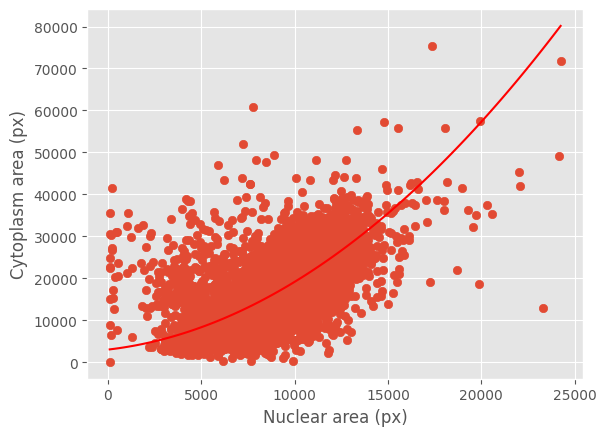

Predict the cyto area of GR from dusp1
Predict the cyto area of GR_noIC from dusp1
+++ Gating Nuc Area +++
DUSP1_ALL original: 34943 rows -> gated: 17474 rows
GR_ALL original:    15962 rows -> gated: 7982 rows
GR_ALL_noIC original:    15937 rows -> gated: 7975 rows


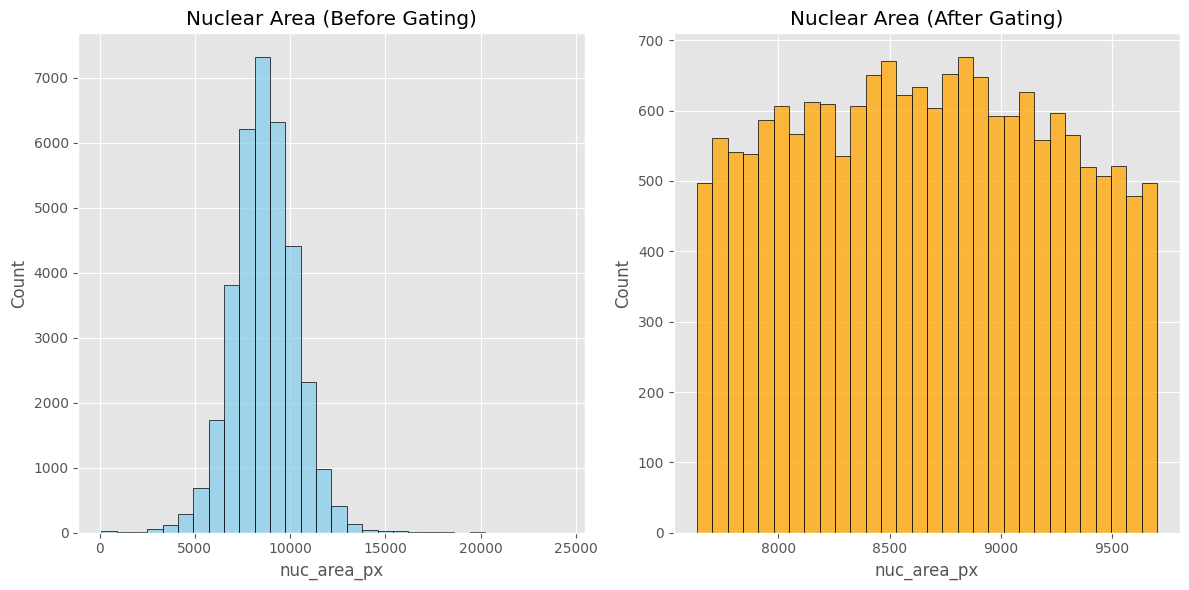

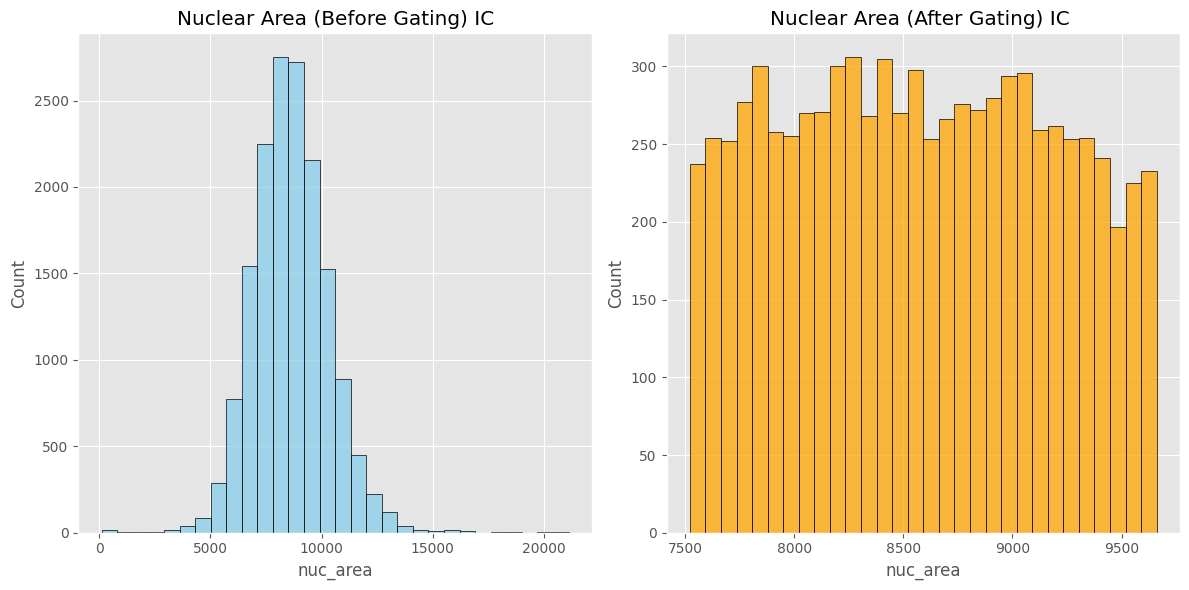

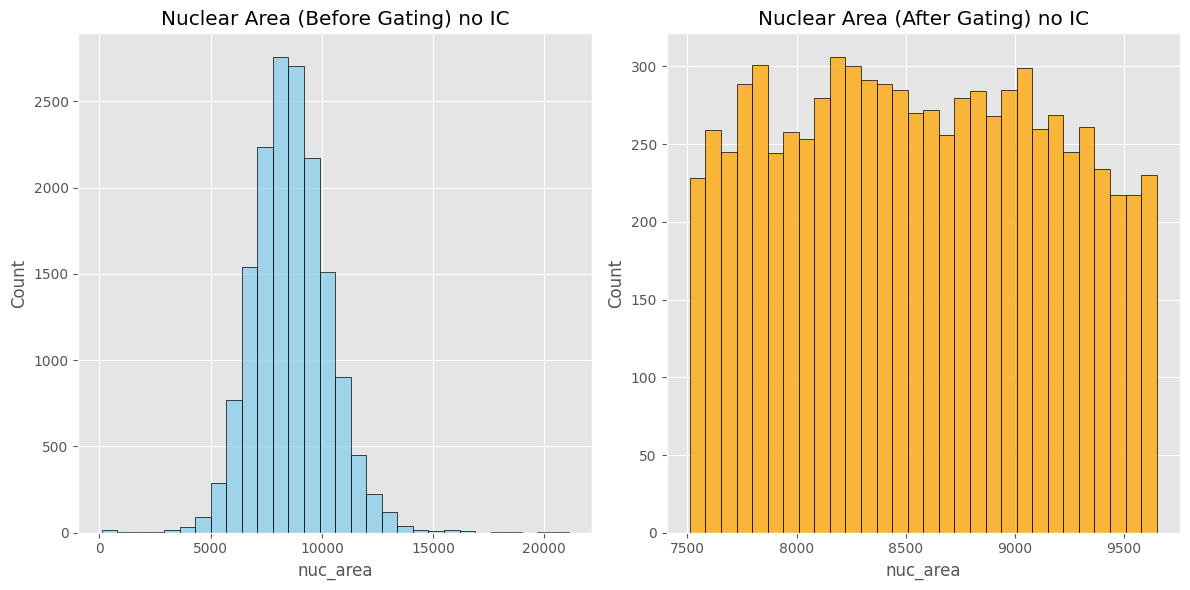

Estimated (Nuc : Cyto) area ratio = 0.5500484289457436
        nucGRint    cytoGRint  normGRnuc  normGRcyt
447  4088.892273  2522.068576         15         19
451  3328.642519  2286.318351         10         16
456  3565.211277  2434.642567         12         17
458  4275.160270  2627.278765         16         20
462  4806.656183  2999.524439         20         25
        nucGRint    cytoGRint  normGRnuc  normGRcyt
452  2752.175537  1889.097168          7         12
453  3782.917969  2331.577148         15         18
455  4945.645020  3260.745117         23         30
456  4053.698486  2611.084229         17         21
458  4609.735840  2867.071533         20         25


In [11]:
# 1) READ INPUT DATA
# =========================
# DUSP1_ALL from above or load from disk:
if 'DUSP1_ALL' in locals():
    df_dusp = DUSP1_ALL
else:
    df_dusp = pd.read_csv('DUSP1_ALL.csv')

# GR_ALL from above or load from disk:
if 'GR_ALL' in locals():
    df_gr = GR_ALL
else:
    df_gr = pd.read_csv('GR_ALL_pregate.csv')

# GR_ALL_noIC from above or load from disk:
if 'GR_ALL_noIC' in locals():
    df_gr_noIC = GR_ALL_noIC
else:
    df_gr_noIC = pd.read_csv('GR_ALL_noIC_pregate.csv')

# 2) FIT POLYNOMIAL TO (NUC, CYTO) FROM DUSP1_ALL
# =========================
# We'll use only the rows that have valid nuc_area_px and cyto_area_px.
num_cells = df_dusp.shape[0]
df_dusp_nonmissing = df_dusp.dropna(subset=['nuc_area_px', 'cyto_area_px']).copy()
print(f'Cells removed because of NaN areas in DUSP1: {df_dusp_nonmissing.shape[0] - num_cells}')

x_nuc = df_dusp_nonmissing['nuc_area_px'].values
y_cyto = df_dusp_nonmissing['cyto_area_px'].values

# Fit a 2nd-degree polynomial: cyto_area_px = a*(nuc_area_px)^2 + b*(nuc_area_px) + c
poly_coeffs = np.polyfit(x_nuc, y_cyto, deg=2)

# optional: for debugging/inspection
print("Fitted polynomial coefficients (a, b, c):", poly_coeffs)
# plot the fitted polynomial on the data
plt.scatter(x_nuc, y_cyto, label='data')
x_fit = np.linspace(x_nuc.min(), x_nuc.max(), 100)
y_fit = np.polyval(poly_coeffs, x_fit)
plt.plot(x_fit, y_fit, label='fitted polynomial', color='red')
plt.xlabel('Nuclear area (px)')
plt.ylabel('Cytoplasm area (px)')
plt.show()


# 3) ESTIMATE CYTO AREA IN GR_ALL
# =========================
# We'll store the computed cytoplasm area in a new column: 'CalcCytoArea'
# Evaluate the polynomial at GR_ALL['nuc_area'].
print('Predict the cyto area of GR from dusp1')
df_gr['CalcCytoArea'] = np.polyval(poly_coeffs, df_gr['nuc_area'])
print('Predict the cyto area of GR_noIC from dusp1')
df_gr_noIC['CalcCytoArea'] = np.polyval(poly_coeffs, df_gr_noIC['nuc_area'])


# 4) GATE BOTH DATAFRAMES ON [25%, 75%] NUCLEAR AREA
# =========================
# We'll define a helper function for gating.
num_cells = df_dusp.shape[0]
def gate_on_nuc_area(df, nuc_col):
    """Return a copy of df gated to [25th, 75th percentile] of nuc_col."""
    lower = df[nuc_col].quantile(0.25)
    upper = df[nuc_col].quantile(0.75)
    return df[(df[nuc_col] >= lower) & (df[nuc_col] <= upper)].copy()

# Gate DUSP1_ALL on nuc_area_px
print('+++ Gating Nuc Area +++')
df_dusp_gated = gate_on_nuc_area(df_dusp_nonmissing, 'nuc_area_px') 

# Gate GR_ALL on nuc_area
df_gr_gated = gate_on_nuc_area(df_gr, 'nuc_area')
df_gr_noIC_gated = gate_on_nuc_area(df_gr_noIC, 'nuc_area')

print(f"DUSP1_ALL original: {len(df_dusp)} rows -> gated: {len(df_dusp_gated)} rows")
print(f"GR_ALL original:    {len(df_gr)} rows -> gated: {len(df_gr_gated)} rows")
print(f"GR_ALL_noIC original:    {len(df_gr_noIC)} rows -> gated: {len(df_gr_noIC_gated)} rows")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_dusp['nuc_area_px'], bins=30, color='skyblue', edgecolor='black')
plt.title("Nuclear Area (Before Gating)")
plt.subplot(1, 2, 2)
sns.histplot(df_dusp_gated['nuc_area_px'], bins=30, color='orange', edgecolor='black')
plt.title("Nuclear Area (After Gating)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_gr['nuc_area'], bins=30, color='skyblue', edgecolor='black')
plt.title("Nuclear Area (Before Gating) IC")
plt.subplot(1, 2, 2)
sns.histplot(df_gr_gated['nuc_area'], bins=30, color='orange', edgecolor='black')
plt.title("Nuclear Area (After Gating) IC ")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_gr_noIC['nuc_area'], bins=30, color='skyblue', edgecolor='black')
plt.title("Nuclear Area (Before Gating) no IC")
plt.subplot(1, 2, 2)
sns.histplot(df_gr_noIC_gated['nuc_area'], bins=30, color='orange', edgecolor='black')
plt.title("Nuclear Area (After Gating) no IC")
plt.tight_layout()
plt.show()
# # (Optional) Save a copy of the gated GR data
# df_gr_gated.to_csv("GR_ALL_Gated_On_Nuc.csv", index=False)

nuc_mean = df_dusp_gated['nuc_area_px'].mean()
cyto_mean = df_dusp_gated['cyto_area_px'].mean()
ratio = nuc_mean / cyto_mean
print("Estimated (Nuc : Cyto) area ratio =", ratio)

# Remove timepoints 20, 40, 60, 90, 150 without replicas
timepoints_to_remove = [20, 40, 60, 90, 150]
df_gr_gated = df_gr_gated[~df_gr_gated['time'].isin(timepoints_to_remove)]
df_gr_noIC_gated = df_gr_noIC_gated[~df_gr_noIC_gated['time'].isin(timepoints_to_remove)]

# # (Optional) Randomly assign Dex=0 rows to 1, 10, 100 nM
# # Find rows where Dex_Conc == 0
# mask_zero = (df_gr_gated['Dex_Conc'] == 0)
# n_zero = mask_zero.sum()
# if n_zero > 0:
#     # Generate random indices in [0, 2] for each zero row
#     rand_indices = np.random.randint(0, 3, size=n_zero)
#     dex_values = [1, 10, 100]
#     df_gr_gated.loc[mask_zero, 'Dex_Conc'] = [dex_values[i] for i in rand_indices]


# 5) COMPUTE "NORMALIZED" GR FOR NUC & CYTO IN GR_ALL
# =========================
#  Define bins & threshold:
binsCyt = 30
threshold = 0.01

#  Sort cytoplasmic intensities:
sortGRcyt = df_gr_gated['cytoGRint'].sort_values().values
sortGRcyt_noIC = df_gr_noIC_gated['cytoGRint'].sort_values().values

#  Identify the indices for the 1% and 99% cutoffs
low_idx  = int(np.ceil(threshold * len(sortGRcyt))) - 1
high_idx = int(np.ceil((1 - threshold) * len(sortGRcyt))) - 1

# Identify the indices for the 1% and 99% cutoffs
low_idx_noIC  = int(np.ceil(threshold * len(sortGRcyt_noIC))) - 1
high_idx_noIC = int(np.ceil((1 - threshold) * len(sortGRcyt_noIC))) - 1

#  Gather the min/max thresholds
minThreshold = sortGRcyt[low_idx]
maxCytGR     = sortGRcyt[high_idx]

# Gather the min/max thresholds
minThreshold_noIC = sortGRcyt_noIC[low_idx_noIC]
maxCytGR_noIC     = sortGRcyt_noIC[high_idx_noIC]

def apply_cyt_norm(values):
    # Scale to [0,1] based on [minThreshold, maxCytGR], then clip
    scaled = (values - minThreshold) / (maxCytGR - minThreshold)
    clipped = np.clip(scaled, 0, 1)
    return np.round(clipped * binsCyt).astype(int)

def apply_cyt_norm_noIC(values):
    # Scale to [0,1] based on [minThreshold, maxCytGR], then clip
    scaled = (values - minThreshold_noIC) / (maxCytGR_noIC - minThreshold_noIC)
    clipped = np.clip(scaled, 0, 1)
    return np.round(clipped * binsCyt).astype(int)

# Compute normGRcyt:
df_gr_gated['normGRcyt'] = apply_cyt_norm(df_gr_gated['cytoGRint'])

# Compute normGRcyt_noIC:
df_gr_noIC_gated['normGRcyt'] = apply_cyt_norm_noIC(df_gr_noIC_gated['cytoGRint'])

# Brian's Matlab logic for the nuclear intensity:
#   'nucGRLevel = ratio * Nuc_GR_avg_int', then scale by the same [minThreshold, maxCytGR].
df_gr_gated['nucGR_Level'] = ratio * df_gr_gated['nucGRint']
df_gr_gated['normGRnuc']   = apply_cyt_norm(df_gr_gated['nucGR_Level'])

df_gr_noIC_gated['nucGR_Level'] = ratio * df_gr_noIC_gated['nucGRint']
df_gr_noIC_gated['normGRnuc']   = apply_cyt_norm_noIC(df_gr_noIC_gated['nucGR_Level'])

# Remove intermediate column:
df_gr_gated.drop(columns=['nucGR_Level'], inplace=True)
df_gr_noIC_gated.drop(columns=['nucGR_Level'], inplace=True)

# Debug: check a few rows
print(df_gr_gated[['nucGRint','cytoGRint','normGRnuc','normGRcyt']].head())
print(df_gr_noIC_gated[['nucGRint','cytoGRint','normGRnuc','normGRcyt']].head())

# SAVE THE GATED DATAFRAMES

In [ ]:
from datetime import datetime

# SAVE THE GATED DATAFRAMES
# =========================
# Gated DUSP1 (unchanged except row filtering)
# Get the current date
current_date = datetime.now().strftime("%b%d%y")

# Save the gated DUSP1 dataframe with the current date in the filename
df_dusp_gated.to_csv(f"DUSP1_ALL_gated_{current_date}.csv", index=False)

# Gated GR with new columns: CalcCytoArea, normGRnuc, normGRcyt
df_gr_gated.to_csv(f"GR_ALL_gated_with_CytoArea_and_normGR_{current_date}.csv", index=False)
df_gr_noIC_gated.to_csv(f"GR_ALL_noIC_gated_with_CytoArea_and_normGR_{current_date}.csv", index=False)

print(f"Saved gated DUSP1 to 'DUSP1_ALL_gated_{current_date}.csv")
print(f"Saved gated GR to 'GR_ALL_gated_CytoArea_normGR_{current_date}.csv")
print(f"Saved gated GR_noIC to 'GR_ALL_noIC_gated_CytoArea_normGR_{current_date}.csv")

Saved gated DUSP1 to 'DUSP1_ALL_gated_{current_date}.csv
Saved gated GR to 'GR_ALL_gated_CytoArea_normGR_{current_date}.csv
Saved gated GR_noIC to 'GR_ALL_noIC_gated_CytoArea_normGR_{current_date}.csv


# Load in gated data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_dusp_gated = pd.read_csv('DUSP1_ALL_gated_Feb1925.csv')
df_gr_gated = pd.read_csv('GR_ALL_gated_with_CytoArea_and_normGR_Feb1925.csv')
df_gr_noIC_gated = pd.read_csv('GR_ALL_noIC_gated_with_CytoArea_and_normGR_Feb1925.csv')

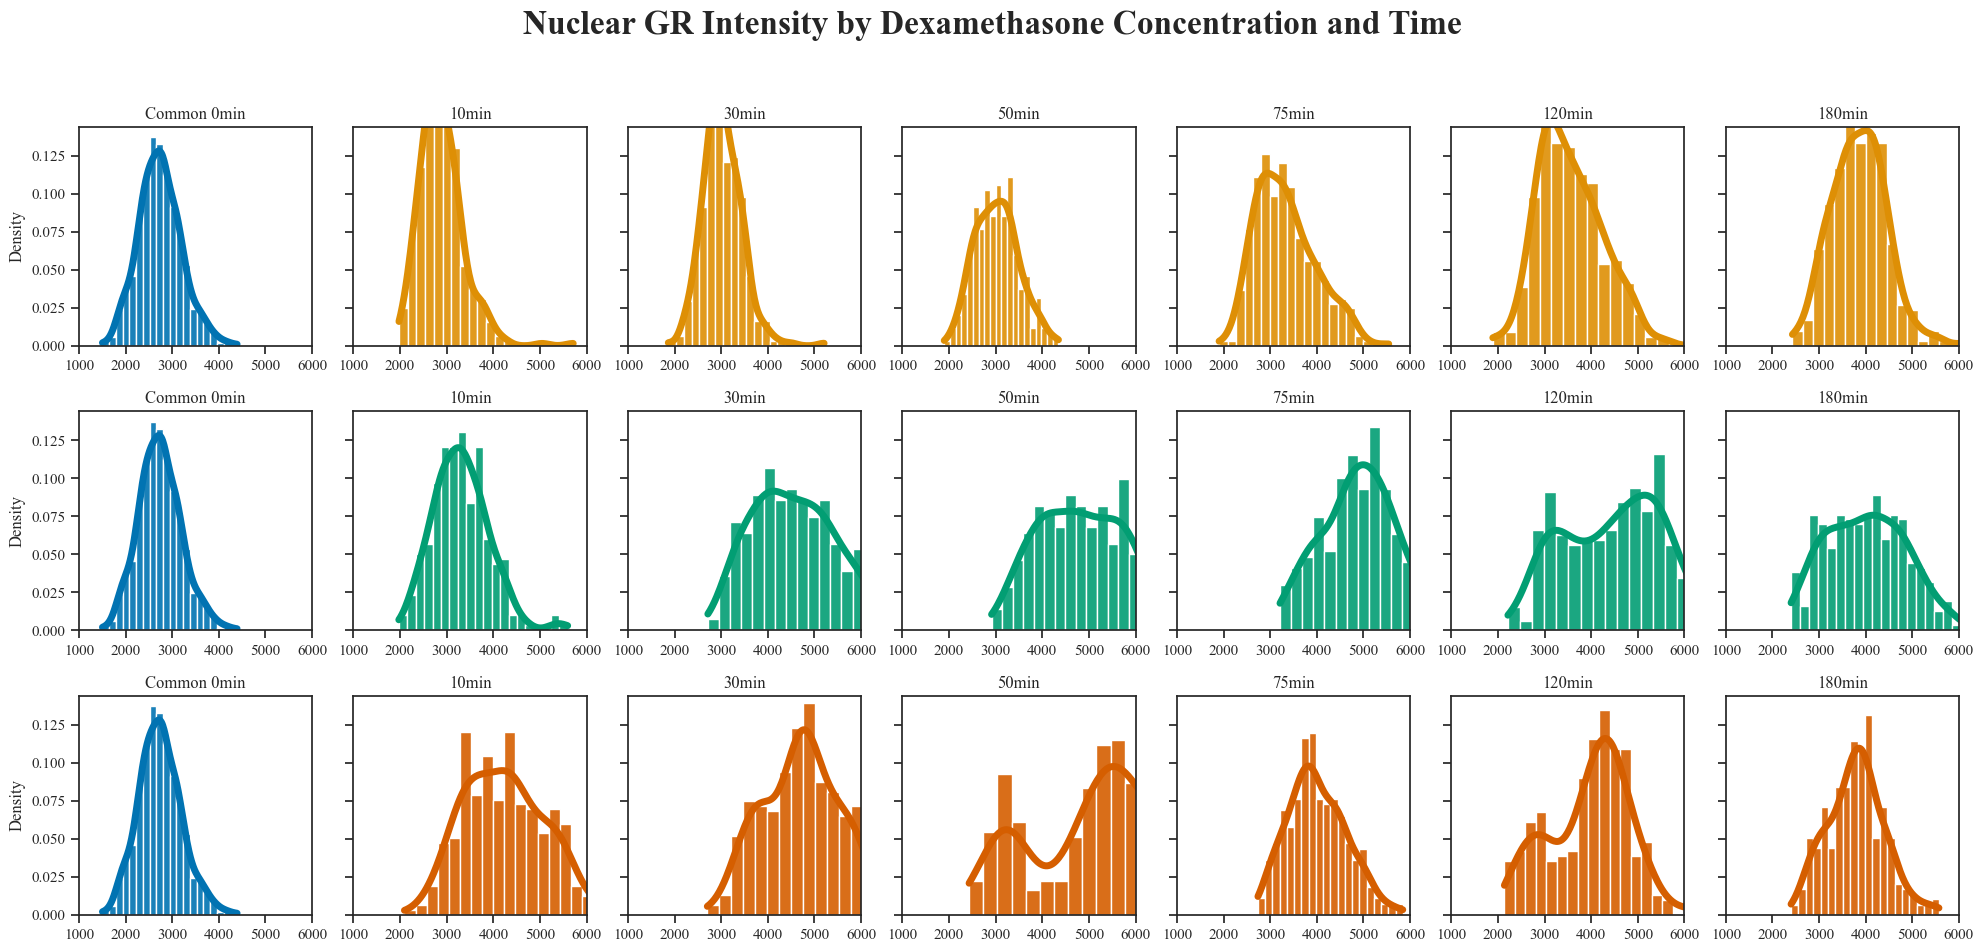

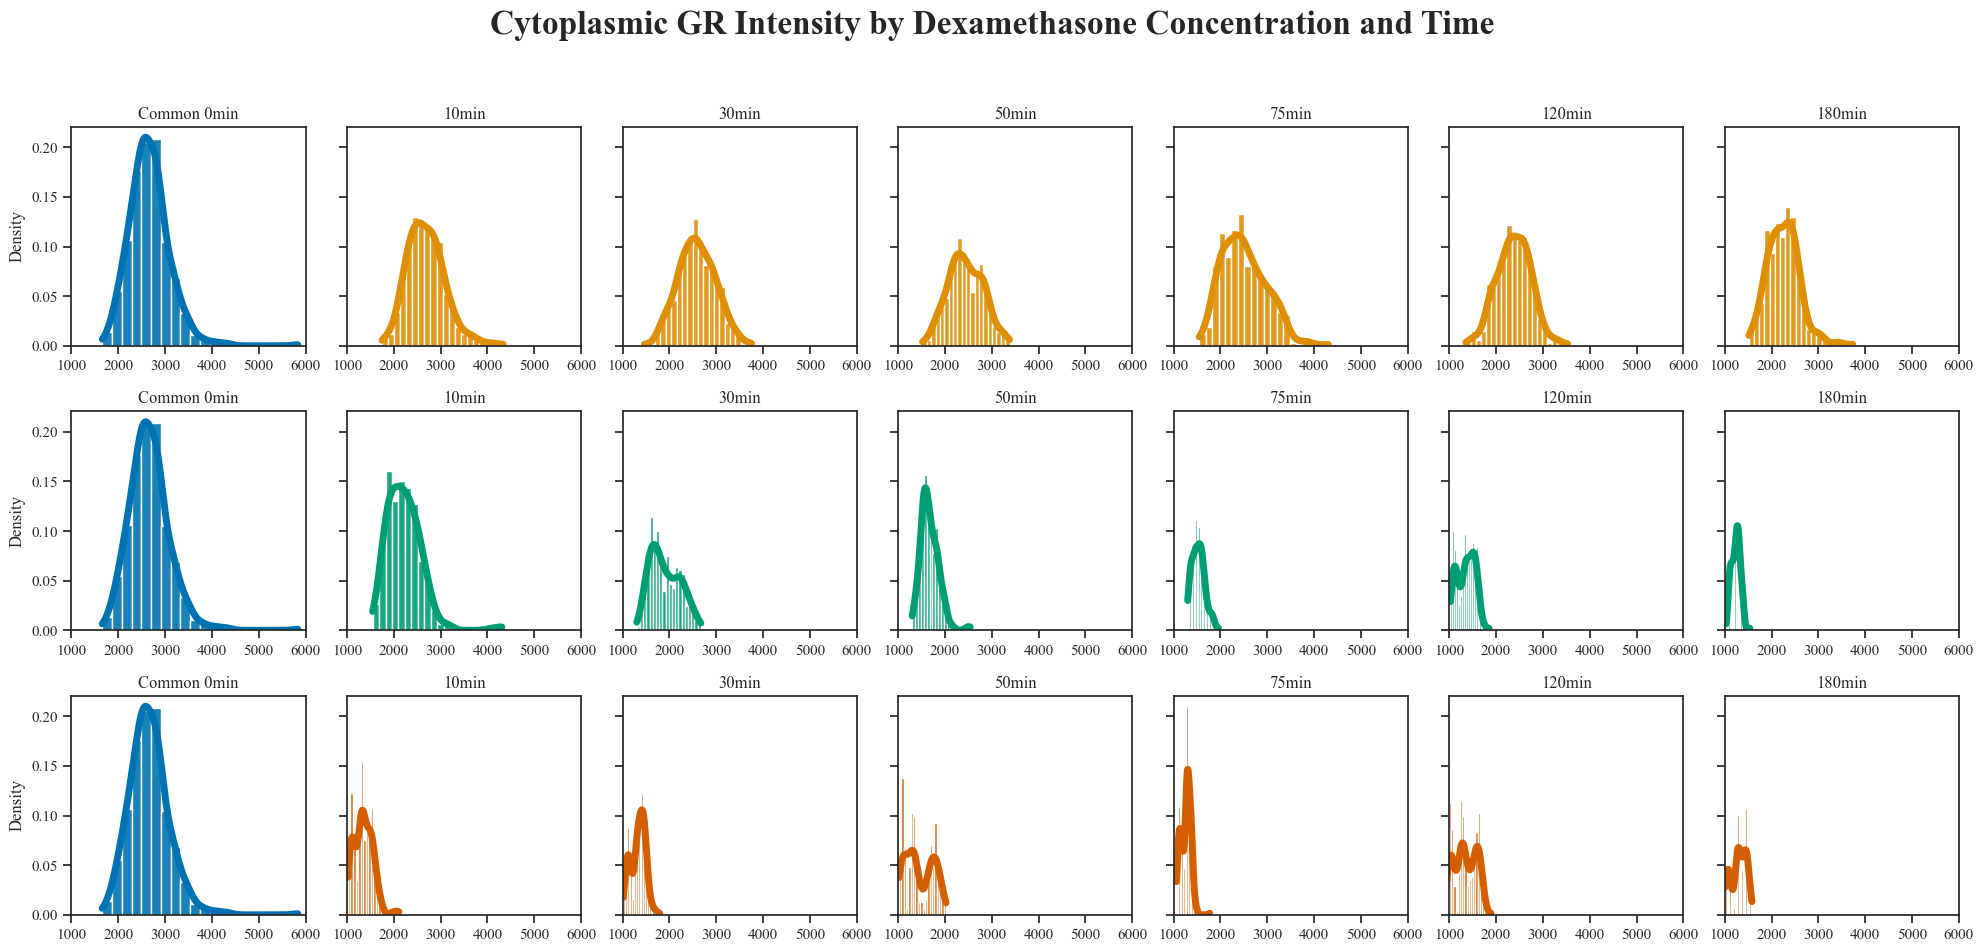

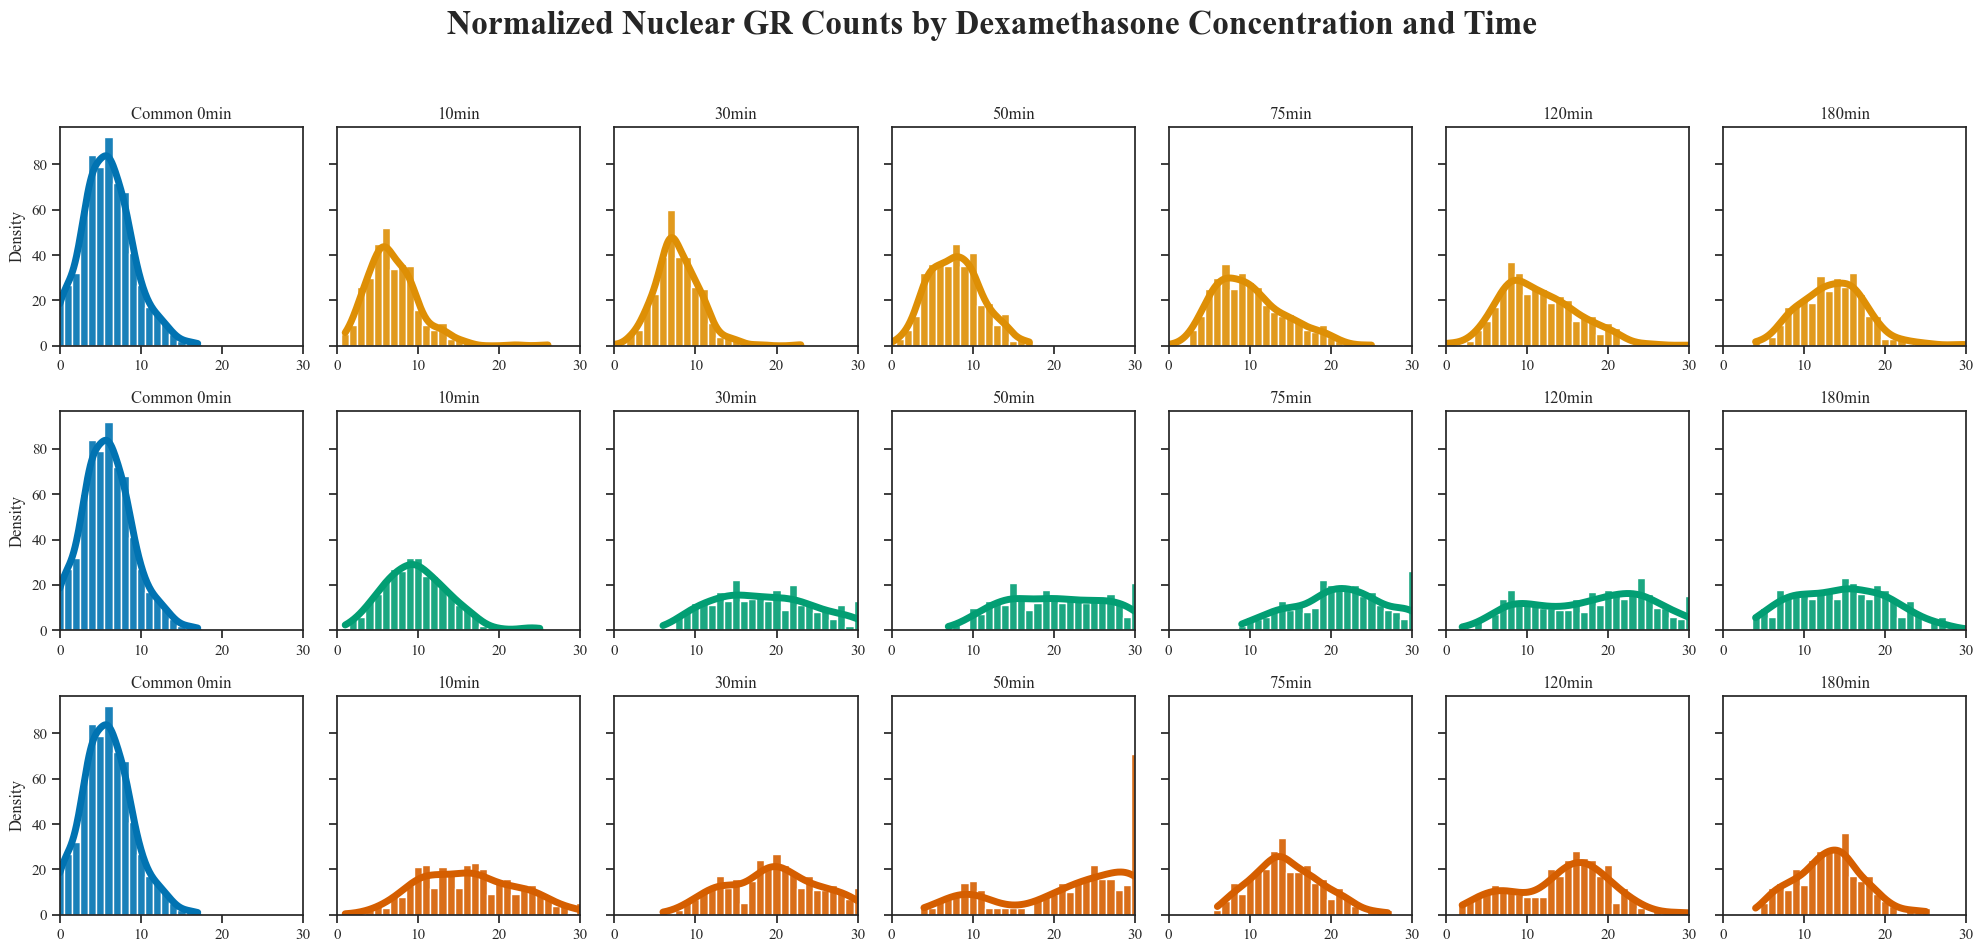

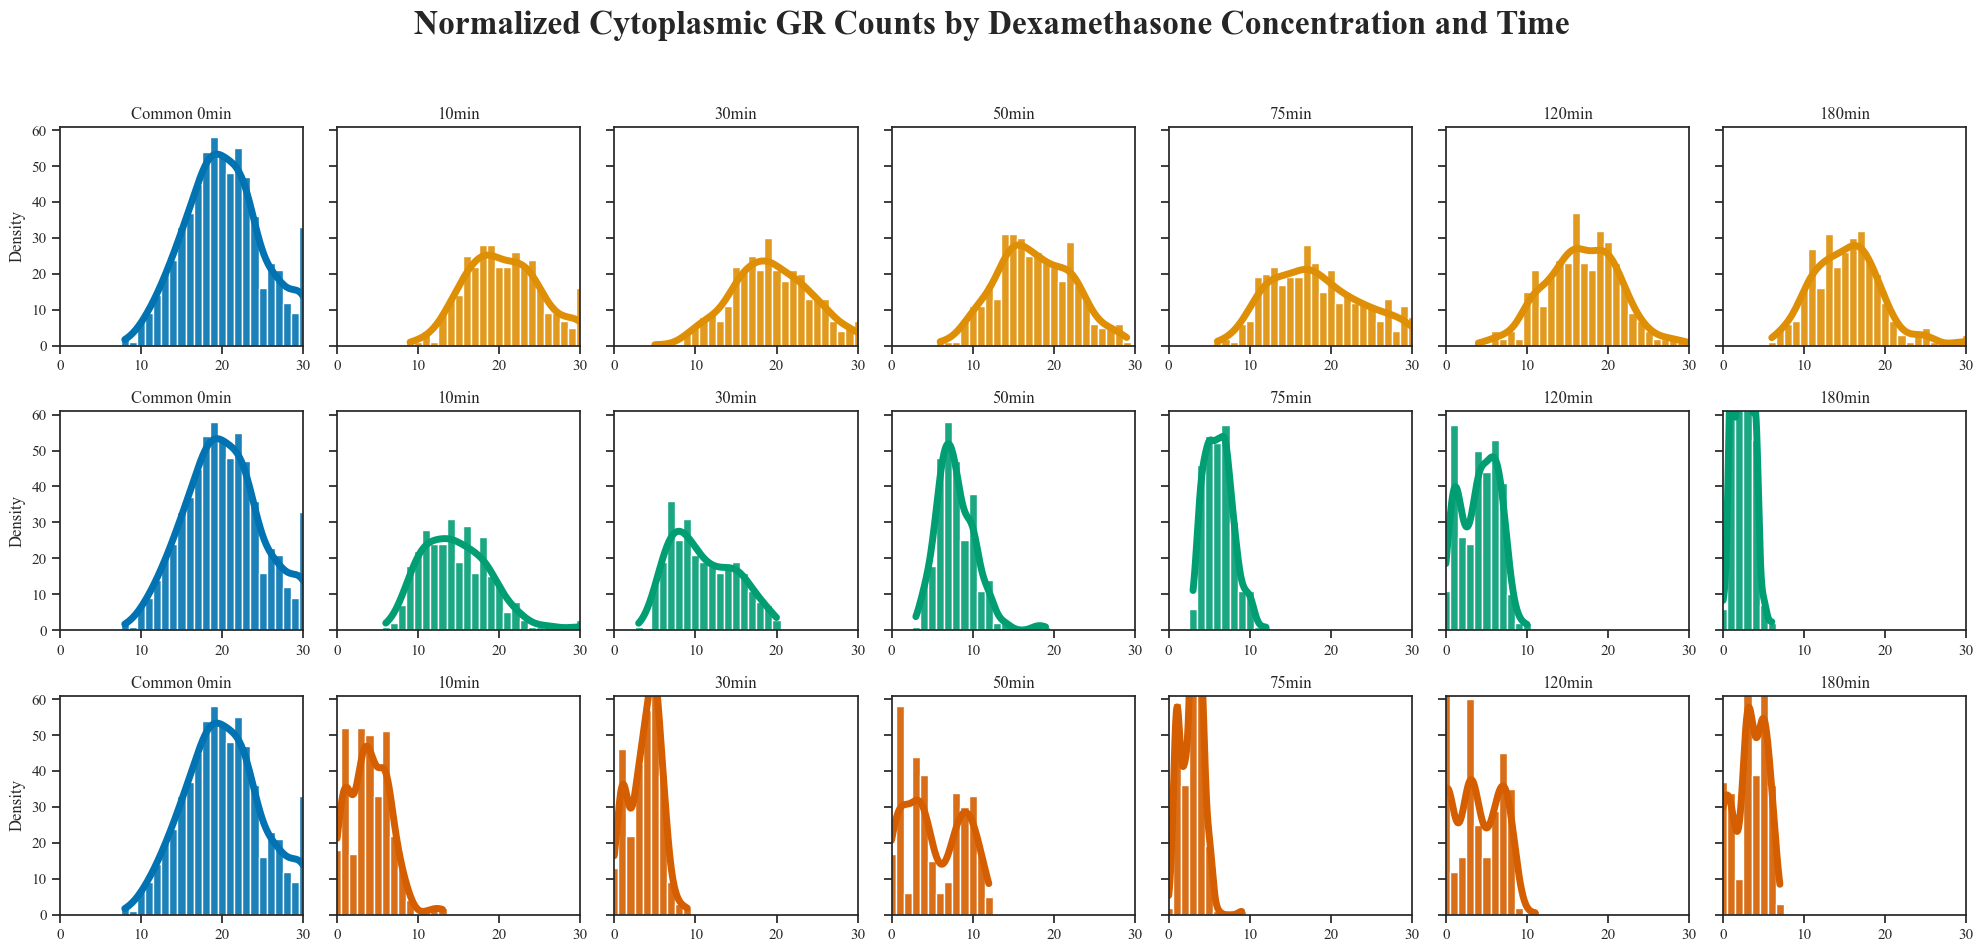

In [52]:
# GR HISTOGRAMS
# =========================
# Set the SNS theme
sns.set_theme(style="ticks", palette="colorblind", context="notebook", font='times new roman')

# Define the concentrations and specific timepoints you want to plot
concentrations = [1, 10, 100]  # nM concentrations
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

# Metrics to plot and their corresponding labels
metrics = ['nucGRint', 'cytoGRint', 'normGRnuc', 'normGRcyt']
labels = {
    'nucGRint': 'Nuclear GR Intensity',
    'cytoGRint': 'Cytoplasmic GR Intensity',
    'normGRnuc': 'Normalized Nuclear GR Counts',
    'normGRcyt': 'Normalized Cytoplasmic GR Counts',
}

# Define axis limits for each metric
axis_limits = {
    'nucGRint': (1000, 6000),
    'cytoGRint': (1000, 6000),
    'normGRnuc': (0, 30),
    'normGRcyt': (0, 30)
}

# Generate colors from the Seaborn colorblind palette
colors = sns.color_palette("colorblind", len(concentrations) + 1)  # Including color for 0 concentration
concentration_color_map = dict(zip([0] + concentrations, colors))

# Plotting
for metric in metrics:
    fig, axes = plt.subplots(len(concentrations), len(desired_timepoints), figsize=(20, 10), sharey='row')
    for i, conc in enumerate(concentrations):
        for j, time in enumerate(desired_timepoints):
            ax = axes[i, j]
            # Filter data for specific concentration and timepoint
            if time == 0:
                data_subset = df_gr_gated[df_gr_gated['time'] == 0]
                color = concentration_color_map[0]
                title = "Common 0min"
            else:
                data_subset = df_gr_gated[(df_gr_gated['dex_conc'] == conc) & (df_gr_gated['time'] == time)]
                color = concentration_color_map[conc]
                title = f"{time}min"
                
            # Use discrete=True for normalized count plots
            discrete_flag = True if metric in ['normGRnuc', 'normGRcyt'] else False
            stat_flag = 'count' if metric in ['normGRnuc', 'normGRcyt'] else 'probability'

            sns.histplot(
                data=data_subset, x=metric, kde=True, color=color, linewidth=1, bins=20, ax=ax,
                element='bars', fill=True, line_kws={'linewidth': 5}, legend=False, alpha=0.9,
                discrete=discrete_flag, stat=stat_flag
            )
            ax.set_xlim(axis_limits[metric])
            ax.set_ylim(0, max(ax.get_ylim()))
            ax.set_title(title)
            ax.set_xlabel(None)  # Only show x-axis label on the bottom plots
            ax.set_ylabel('Density' if j == 0 else '')  # Only show y-axis label on the first column

    plt.suptitle(f"{labels[metric]} by Dexamethasone Concentration and Time", fontsize=24, fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.show()

In [ ]:
# GR Split-Voilin Plots

# Set the Seaborn style
sns.set_theme(style="ticks", palette="colorblind", context="poster", font='times new roman')

# Define the concentrations and specific timepoints you want to plot
concentrations = [0, 1, 10, 100]  # Including 0 concentration for baseline
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

# Prepare a DataFrame to store baseline values for each metric at time 0
baseline_data = df_gr_gated[df_gr_gated['dex_conc'] == 0].groupby('time').mean(numeric_only=True)

# Metrics to plot
metrics = ['nucGRint', 'cytoGRint'] # , 'normGRnuc', 'normGRcyt', 'nuc_cyto_ratio'

# Calculate Log2 fold changes
for metric in metrics:
    baseline_column = f'baseline_{metric}'
    baseline_data[baseline_column] = baseline_data[metric]
    df_gr_gated[f'log2fc_{metric}'] = df_gr_gated.apply(
    lambda row: np.log2(row[metric] / baseline_data.at[0, metric]) if row['time'] != 0 else 0, axis=1)

# Melt the DataFrame to have 'metric' and 'log2fc_value' columns
melted_GR_data = df_gr_gated.melt(id_vars=['dex_conc', 'time'], value_vars=[f'log2fc_{m}' for m in metrics],
                              var_name='metric', value_name='log2fc_value')

# Update the 'metric' column to have nicer labels
melted_GR_data['metric'] = melted_GR_data['metric'].str.replace('log2fc_', '').str.replace('_', ' ').str.title()

# Plotting
fig, axes = plt.subplots(1, len(desired_timepoints), figsize=(15, 5), sharey=True)
fig.suptitle('GR Intensities', fontsize=20, fontweight='bold', y=0.9)

for j, time in enumerate(desired_timepoints):
    ax = axes[j]
    data_subset = melted_GR_data[melted_GR_data['time'] == time]
    sns.violinplot(x='dex_conc', y='log2fc_value', hue='metric', data=data_subset, linewidth=2.0, ax=ax, density_norm='width', split=True)
    ax.set_title(f"{time} min", fontsize=20, fontweight='bold')
    ax.set_xlabel(None)
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=10, width=2)
    ax.tick_params(axis='y', labelsize=10)
    if j > 0:
        ax.set_ylabel('')  # Remove the y-label for all but the first subplot
    else:
        ax.set_ylabel('Log2 Fold Change', fontsize=16, fontweight='bold')
    ax.get_legend().remove()  # Remove the legend

# Set x-label for all subplots
fig.text(0.5, 0.004, 'Dexamethasone Concentration (nM)', ha='center', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

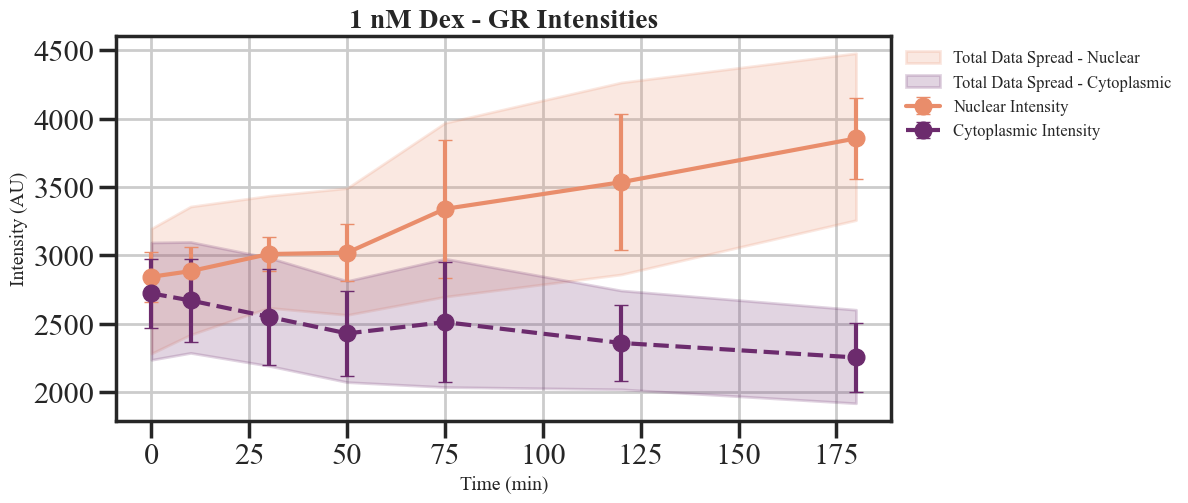

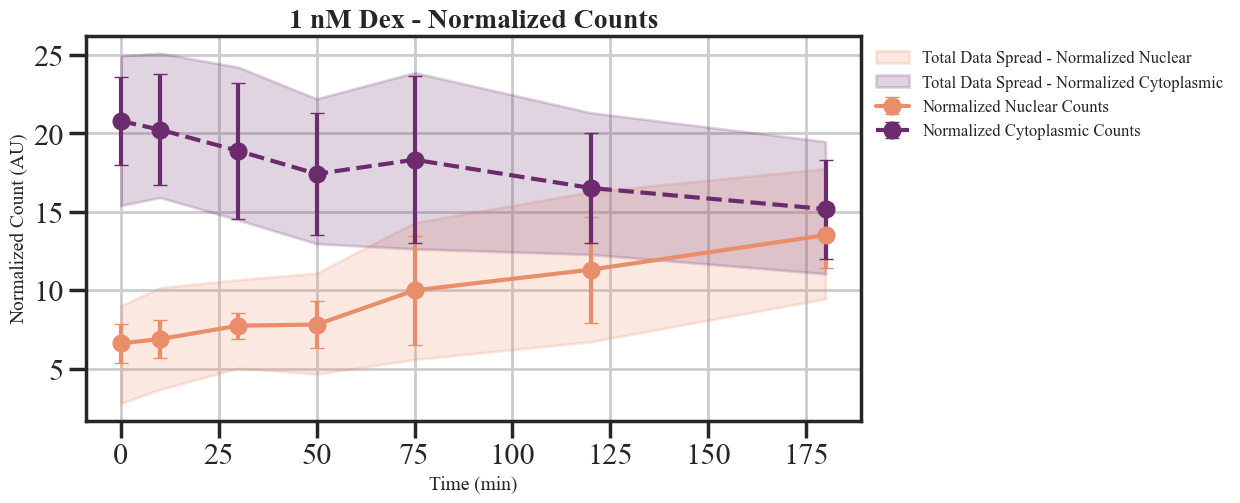

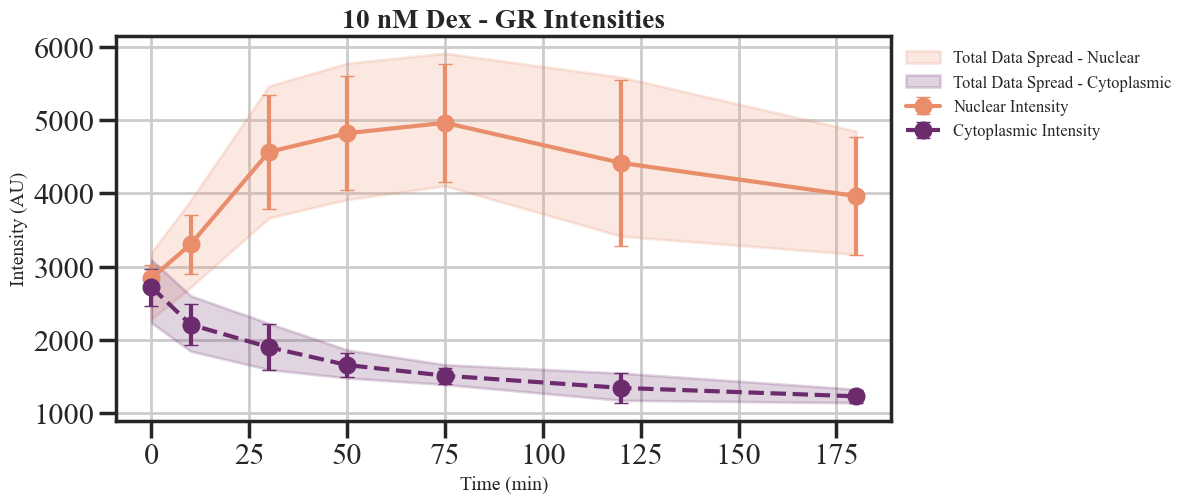

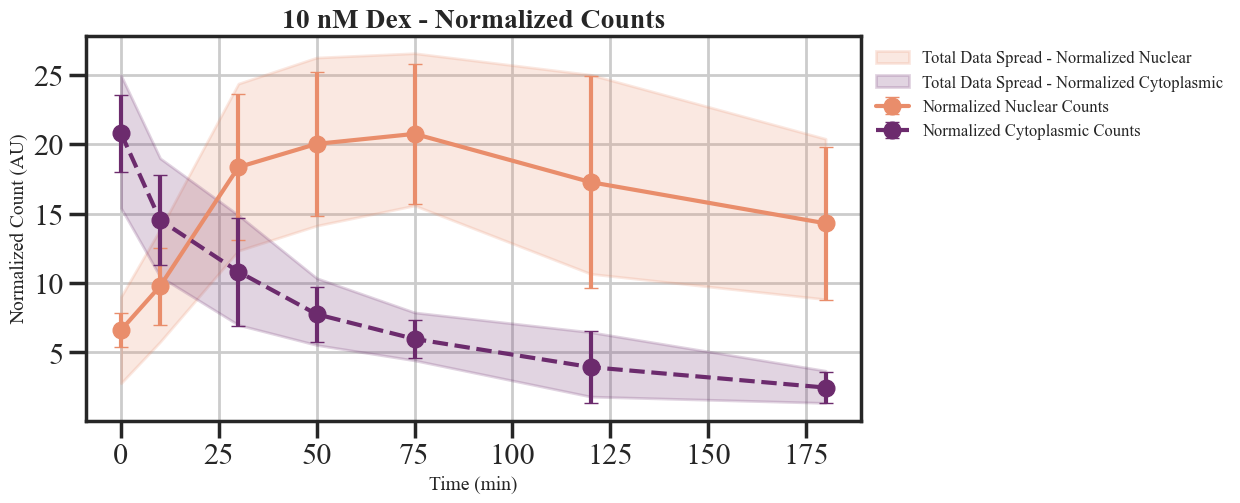

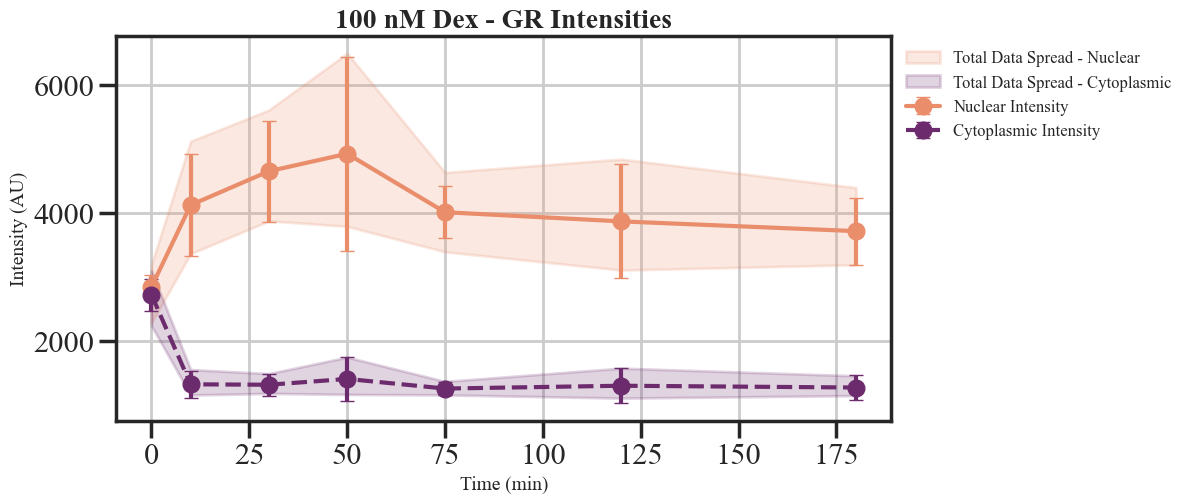

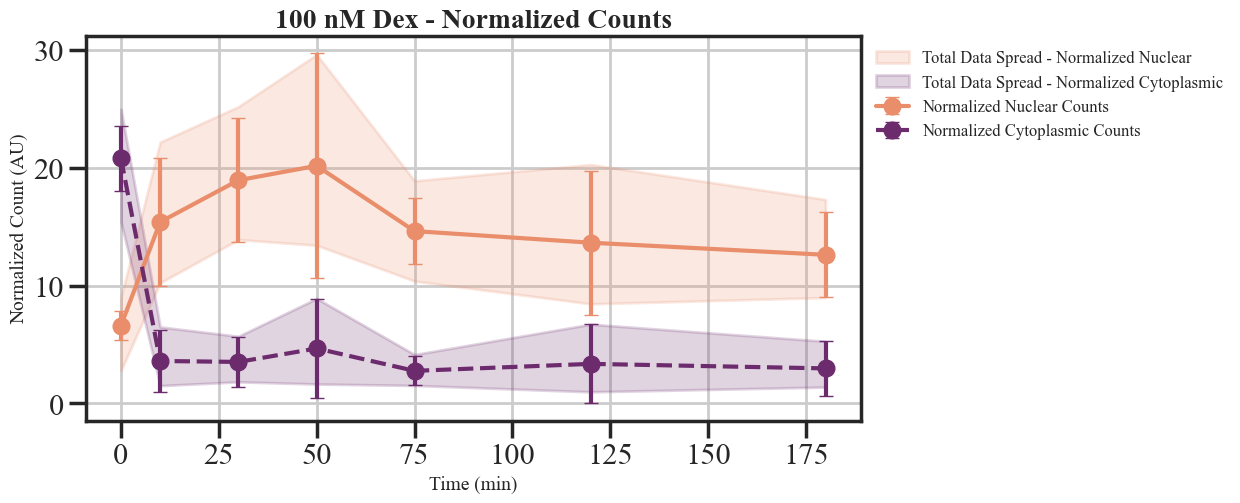

In [47]:
# Line Plots for GR Intensities with Error Bars as Standard Deviation of the replica means, and Total Data Spread as Shaded Area

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
GR_data = pd.read_csv('GR_ALL_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()

# Calculate means for each replica
replica_means = GR_data.groupby(['dex_conc', 'time', 'replica']).agg({
    'nucGRint': 'mean',
    'cytoGRint': 'mean',
    'normGRnuc': 'mean',
    'normGRcyt': 'mean'
}).reset_index()

# Calculate the mean and standard deviation of the replica means
summary_stats = replica_means.groupby(['dex_conc', 'time']).agg({
    'nucGRint': ['mean', 'std'],
    'cytoGRint': ['mean', 'std'],
    'normGRnuc': ['mean', 'std'],
    'normGRcyt': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
summary_stats.columns = ['dex_conc', 'time', 'mean_nuc_int', 'std_nuc_int', 'mean_cyto_int', 'std_cyto_int', 'mean_norm_nuc', 'std_norm_nuc', 'mean_norm_cyto', 'std_norm_cyto']

# Calculate overall mean and standard deviation for each concentration and time point
overall_stats = GR_data.groupby(['dex_conc', 'time']).agg({
    'nucGRint': ['mean', 'std'],
    'cytoGRint': ['mean', 'std'],
    'normGRnuc': ['mean', 'std'],
    'normGRcyt': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
overall_stats.columns = ['dex_conc', 'time', 'overall_mean_nuc', 'overall_std_nuc', 'overall_mean_cyto', 'overall_std_cyto', 'overall_mean_norm_nuc', 'overall_std_norm_nuc', 'overall_mean_norm_cyto', 'overall_std_norm_cyto']

# Extract 0 min data (shared baseline from dex_conc == 0)
zero_min_summary = summary_stats[summary_stats['time'] == 0]
zero_min_overall = overall_stats[overall_stats['time'] == 0]

# Set Seaborn Theme
sns.set_theme(style="ticks", palette="flare", context="poster", font='Times New Roman')

# Define color palette
palette = sns.color_palette("flare", as_cmap=False)
colors_nuc_cyto = [palette[0], palette[-1]]  # Nuclear = First Color, Cytoplasmic = Last Color

# Define the desired time points
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

for conc in [1, 10, 100]:
    # Filter data for plotting
    subset_summary = summary_stats[(summary_stats['dex_conc'] == conc) & (summary_stats['time'].isin(desired_timepoints))]
    subset_overall = overall_stats[(overall_stats['dex_conc'] == conc) & (overall_stats['time'].isin(desired_timepoints))]

    # Add 0 min time point to all subsets
    subset_summary = pd.concat([zero_min_summary, subset_summary], ignore_index=True)
    subset_overall = pd.concat([zero_min_overall, subset_overall], ignore_index=True)

    ### **PLOT 1: INTENSITY PLOTS (NUCLEAR & CYTOPLASMIC)**
    plt.figure(figsize=(10, 5))

    # Nuclear Intensity
    plt.errorbar(subset_summary['time'], subset_summary['mean_nuc_int'],
                 yerr=subset_summary['std_nuc_int'], fmt='-o', color=colors_nuc_cyto[0], capsize=5,
                 label='Nuclear Intensity')

    # Shaded area for Nuclear Total Variability
    plt.fill_between(subset_overall['time'],
                     subset_overall['overall_mean_nuc'] - subset_overall['overall_std_nuc'],
                     subset_overall['overall_mean_nuc'] + subset_overall['overall_std_nuc'],
                     color=colors_nuc_cyto[0], alpha=0.2, label='Total Data Spread - Nuclear')

    # Cytoplasmic Intensity
    plt.errorbar(subset_summary['time'], subset_summary['mean_cyto_int'],
                 yerr=subset_summary['std_cyto_int'], fmt='--o', color=colors_nuc_cyto[1], capsize=5,
                 label='Cytoplasmic Intensity')

    # Shaded area for Cytoplasmic Total Variability
    plt.fill_between(subset_overall['time'],
                     subset_overall['overall_mean_cyto'] - subset_overall['overall_std_cyto'],
                     subset_overall['overall_mean_cyto'] + subset_overall['overall_std_cyto'],
                     color=colors_nuc_cyto[1], alpha=0.2, label='Total Data Spread - Cytoplasmic')

    # Customize plot
    plt.title(f'{conc} nM Dex - GR Intensities', fontsize=20, fontweight='bold')
    plt.xlabel('Time (min)', fontsize=14)
    plt.ylabel('Intensity (AU)', fontsize=14)
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))

    plt.show()

    ### **PLOT 2: NORMALIZED COUNTS PLOTS (NUCLEAR & CYTOPLASMIC)**
    plt.figure(figsize=(10, 5))

    # Nuclear Normalized Counts
    plt.errorbar(subset_summary['time'], subset_summary['mean_norm_nuc'],
                 yerr=subset_summary['std_norm_nuc'], fmt='-o', color=colors_nuc_cyto[0], capsize=5,
                 label='Normalized Nuclear Counts')

    # Shaded area for Nuclear Normalized Total Variability
    plt.fill_between(subset_overall['time'],
                     subset_overall['overall_mean_norm_nuc'] - subset_overall['overall_std_norm_nuc'],
                     subset_overall['overall_mean_norm_nuc'] + subset_overall['overall_std_norm_nuc'],
                     color=colors_nuc_cyto[0], alpha=0.2, label='Total Data Spread - Normalized Nuclear')

    # Cytoplasmic Normalized Counts
    plt.errorbar(subset_summary['time'], subset_summary['mean_norm_cyto'],
                 yerr=subset_summary['std_norm_cyto'], fmt='--o', color=colors_nuc_cyto[1], capsize=5,
                 label='Normalized Cytoplasmic Counts')

    # Shaded area for Cytoplasmic Normalized Total Variability
    plt.fill_between(subset_overall['time'],
                     subset_overall['overall_mean_norm_cyto'] - subset_overall['overall_std_norm_cyto'],
                     subset_overall['overall_mean_norm_cyto'] + subset_overall['overall_std_norm_cyto'],
                     color=colors_nuc_cyto[1], alpha=0.2, label='Total Data Spread - Normalized Cytoplasmic')

    # Customize plot
    plt.title(f'{conc} nM Dex - Normalized Counts', fontsize=20, fontweight='bold')
    plt.xlabel('Time (min)', fontsize=14)
    plt.ylabel('Normalized Count (AU)', fontsize=14)
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))

    plt.show()


## Illumination Correction Comparison

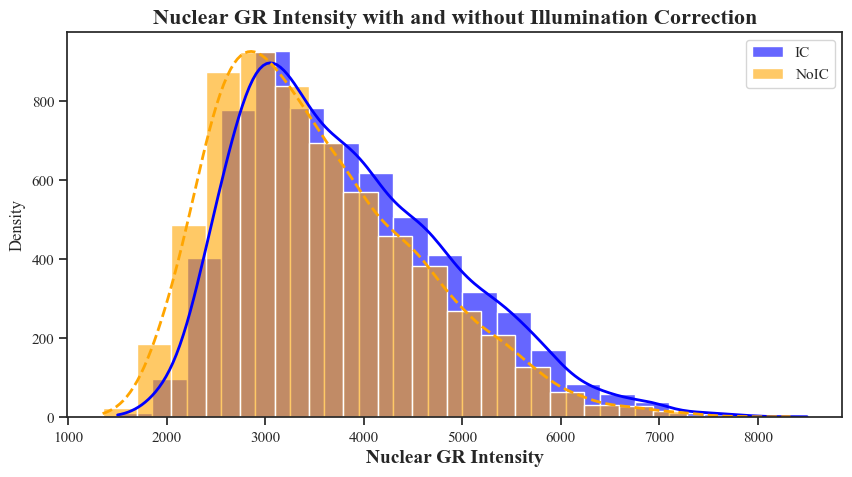

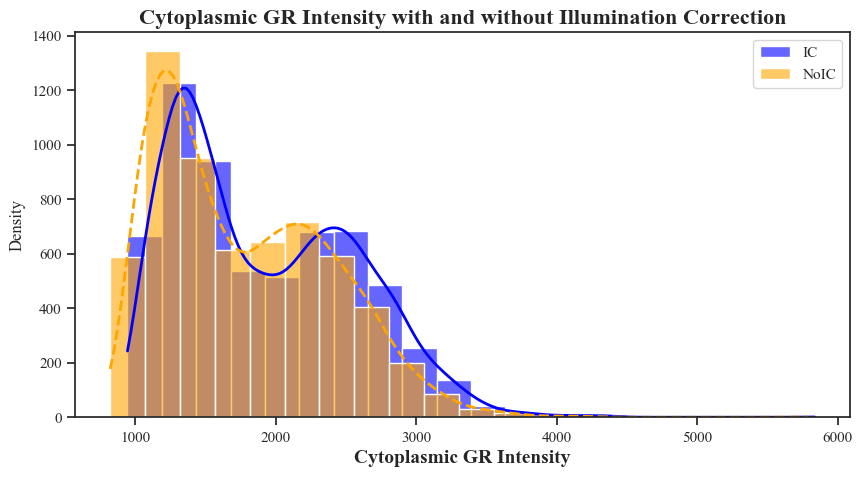

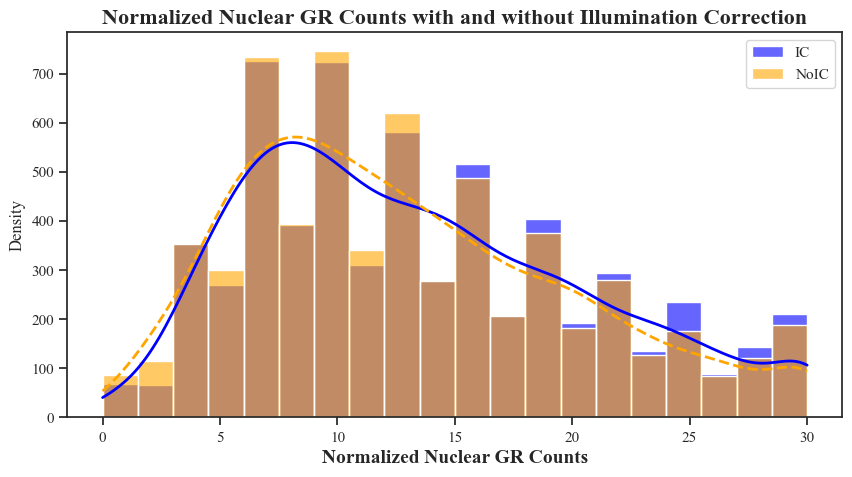

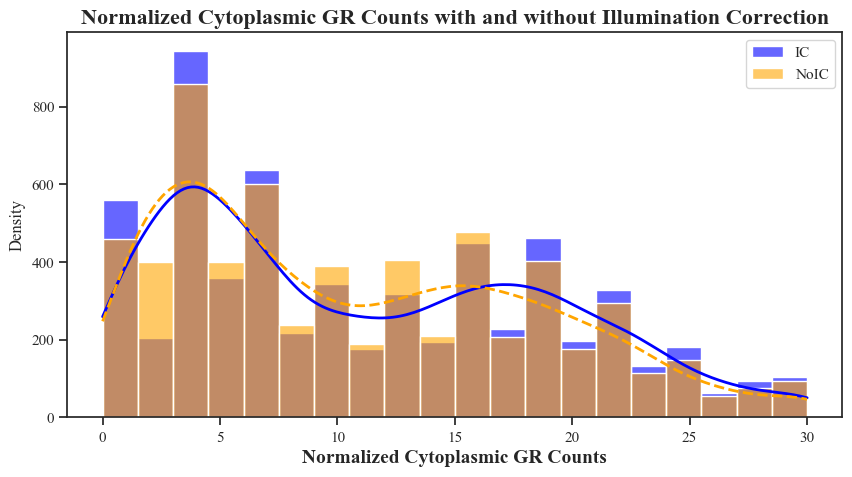

  Dataset  Number of Cells  Mean Nuclear GR Intensity  \
0      IC             6190                3836.673789   
1    NoIC             6190                3529.258475   

   Std Nuclear GR Intensity  Mean Cytoplasmic GR Intensity  \
0               1073.786436                    1927.174378   
1               1036.803680                    1773.137417   

   Std Cytoplasmic GR Intensity  
0                    641.124195  
1                    607.973108  


In [38]:
# Load your data
df_gr_gated = pd.read_csv('GR_ALL_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()  # IC Data
df_gr_noIC_gated = pd.read_csv('GR_ALL_noIC_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()  # NoIC Data

# Set Seaborn Theme
sns.set_theme(style="ticks", palette="colorblind", context="notebook", font='Times New Roman')


# Define metrics and labels
metrics = ['nucGRint', 'cytoGRint', 'normGRnuc', 'normGRcyt']
labels = {
    'nucGRint': 'Nuclear GR Intensity',
    'cytoGRint': 'Cytoplasmic GR Intensity',
    'normGRnuc': 'Normalized Nuclear GR Counts',
    'normGRcyt': 'Normalized Cytoplasmic GR Counts',
}

# --------------------------
# Histogram Comparisons (IC vs. NoIC overlay)
# --------------------------
for metric in metrics:
    plt.figure(figsize=(10, 5))

    # IC Histogram
    sns.histplot(df_gr_gated, x=metric, kde=True, bins=20, color='blue', alpha=0.6, label="IC", line_kws={"linewidth": 2})

    # NoIC Histogram
    sns.histplot(df_gr_noIC_gated, x=metric, kde=True, bins=20, color='orange', alpha=0.6, label="NoIC", line_kws={"linewidth": 2, "linestyle": "--"})

    plt.xlabel(labels[metric], fontsize=14, fontweight='bold')
    plt.ylabel("Density", fontsize=12)
    plt.title(f"{labels[metric]} with and without Illumination Correction", fontsize=16, fontweight='bold')
    plt.legend()
    plt.show()



# --------------------------
# Line Plots (IC vs. NoIC over time)
# --------------------------
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

# Define colors for nuclear and cytoplasmic intensities
colors_nuc_cyto = sns.color_palette("colorblind", 2)

# Compute Summary Statistics for IC and NoIC
summary_stats_ic = df_gr_gated.groupby(["dex_conc", "time"]).agg(
    mean_nucGR=("nucGRint", "mean"),
    std_nucGR=("nucGRint", "std"),
    mean_cytoGR=("cytoGRint", "mean"),
    std_cytoGR=("cytoGRint", "std")
).reset_index()

summary_stats_noic = df_gr_noIC_gated.groupby(["dex_conc", "time"]).agg(
    mean_nucGR=("nucGRint", "mean"),
    std_nucGR=("nucGRint", "std"),
    mean_cytoGR=("cytoGRint", "mean"),
    std_cytoGR=("cytoGRint", "std")
).reset_index()


# --------------------------
# Summary Statistics
# --------------------------
summary_stats = pd.DataFrame({
    "Dataset": ["IC", "NoIC"],
    "Number of Cells": [df_gr_gated.shape[0], df_gr_noIC_gated.shape[0]],
    "Mean Nuclear GR Intensity": [df_gr_gated["nucGRint"].mean(), df_gr_noIC_gated["nucGRint"].mean()],
    "Std Nuclear GR Intensity": [df_gr_gated["nucGRint"].std(), df_gr_noIC_gated["nucGRint"].std()],
    "Mean Cytoplasmic GR Intensity": [df_gr_gated["cytoGRint"].mean(), df_gr_noIC_gated["cytoGRint"].mean()],
    "Std Cytoplasmic GR Intensity": [df_gr_gated["cytoGRint"].std(), df_gr_noIC_gated["cytoGRint"].std()],
})

print(summary_stats)

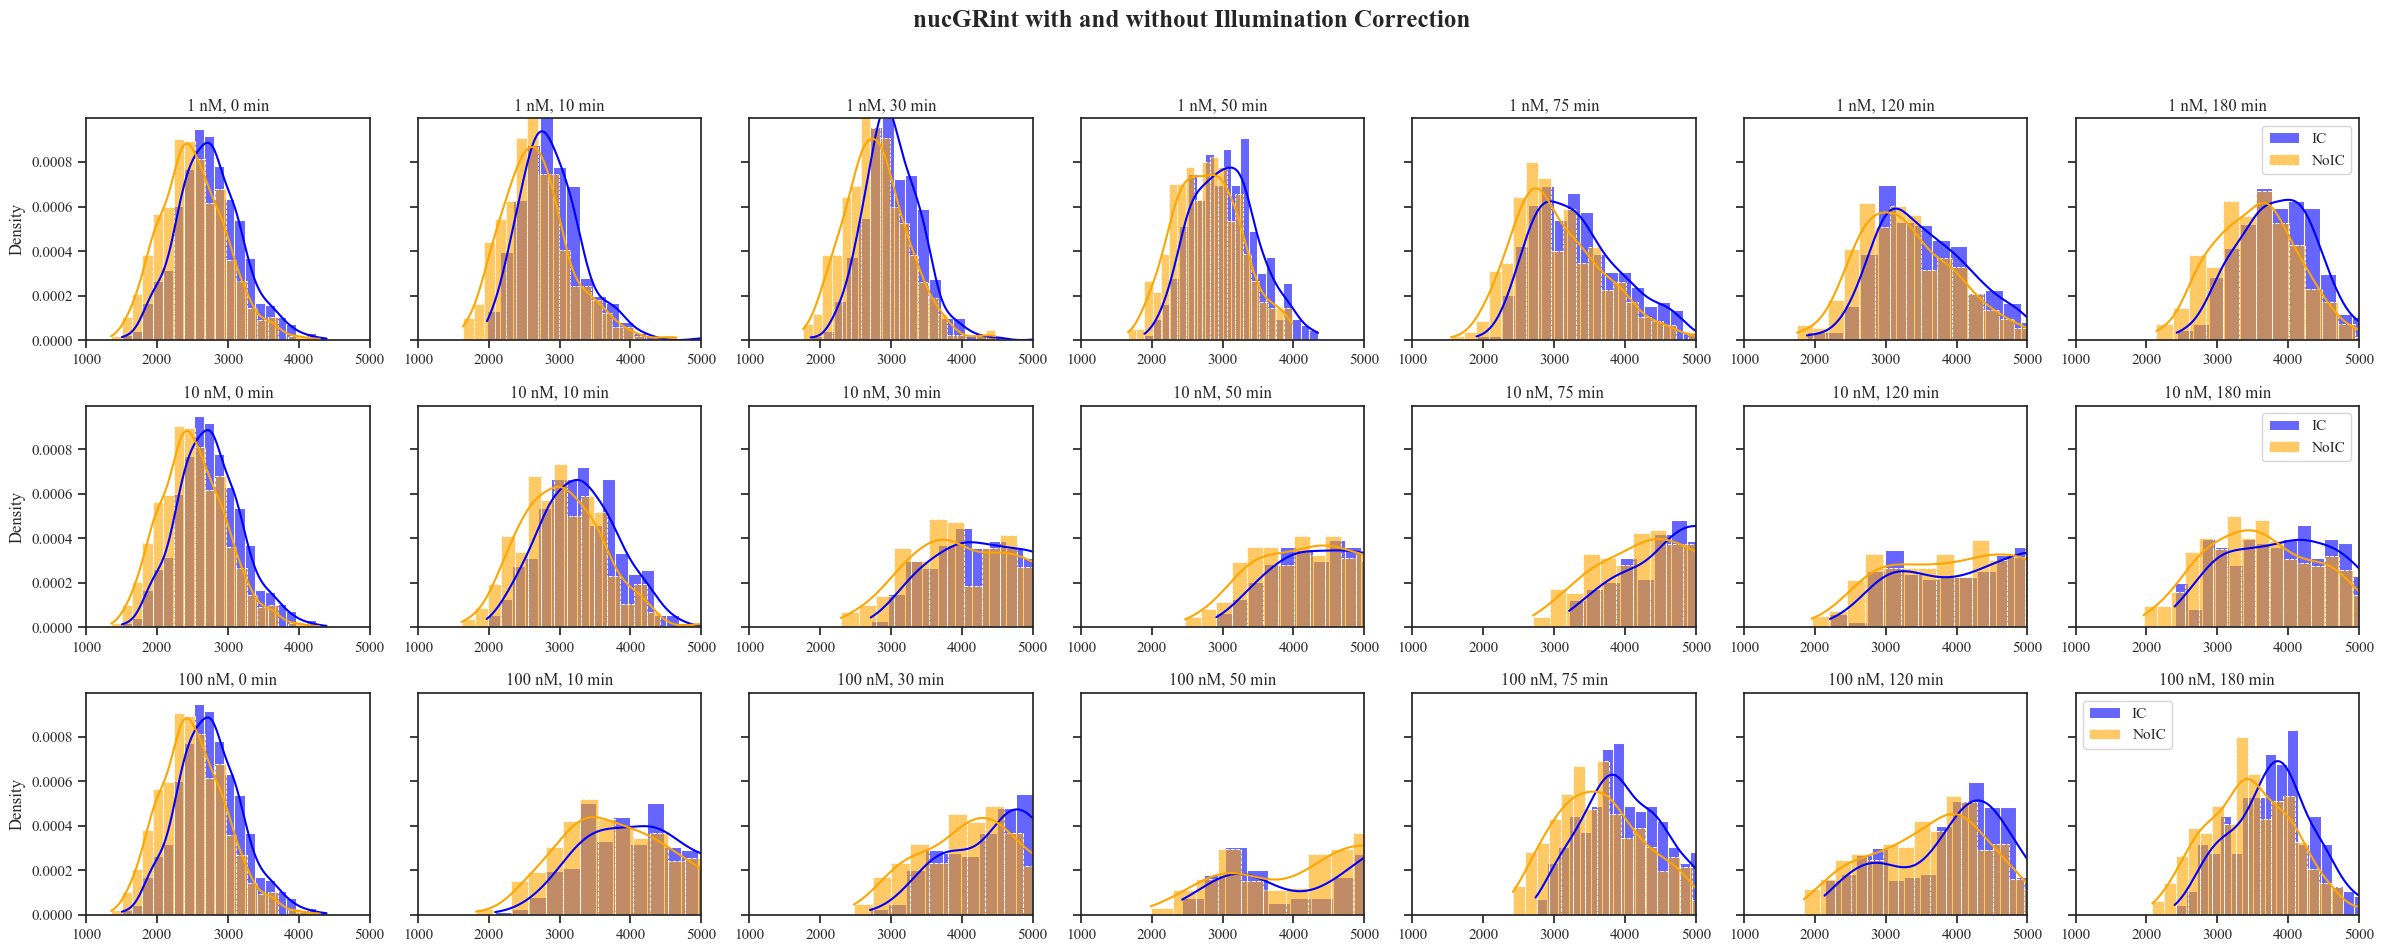

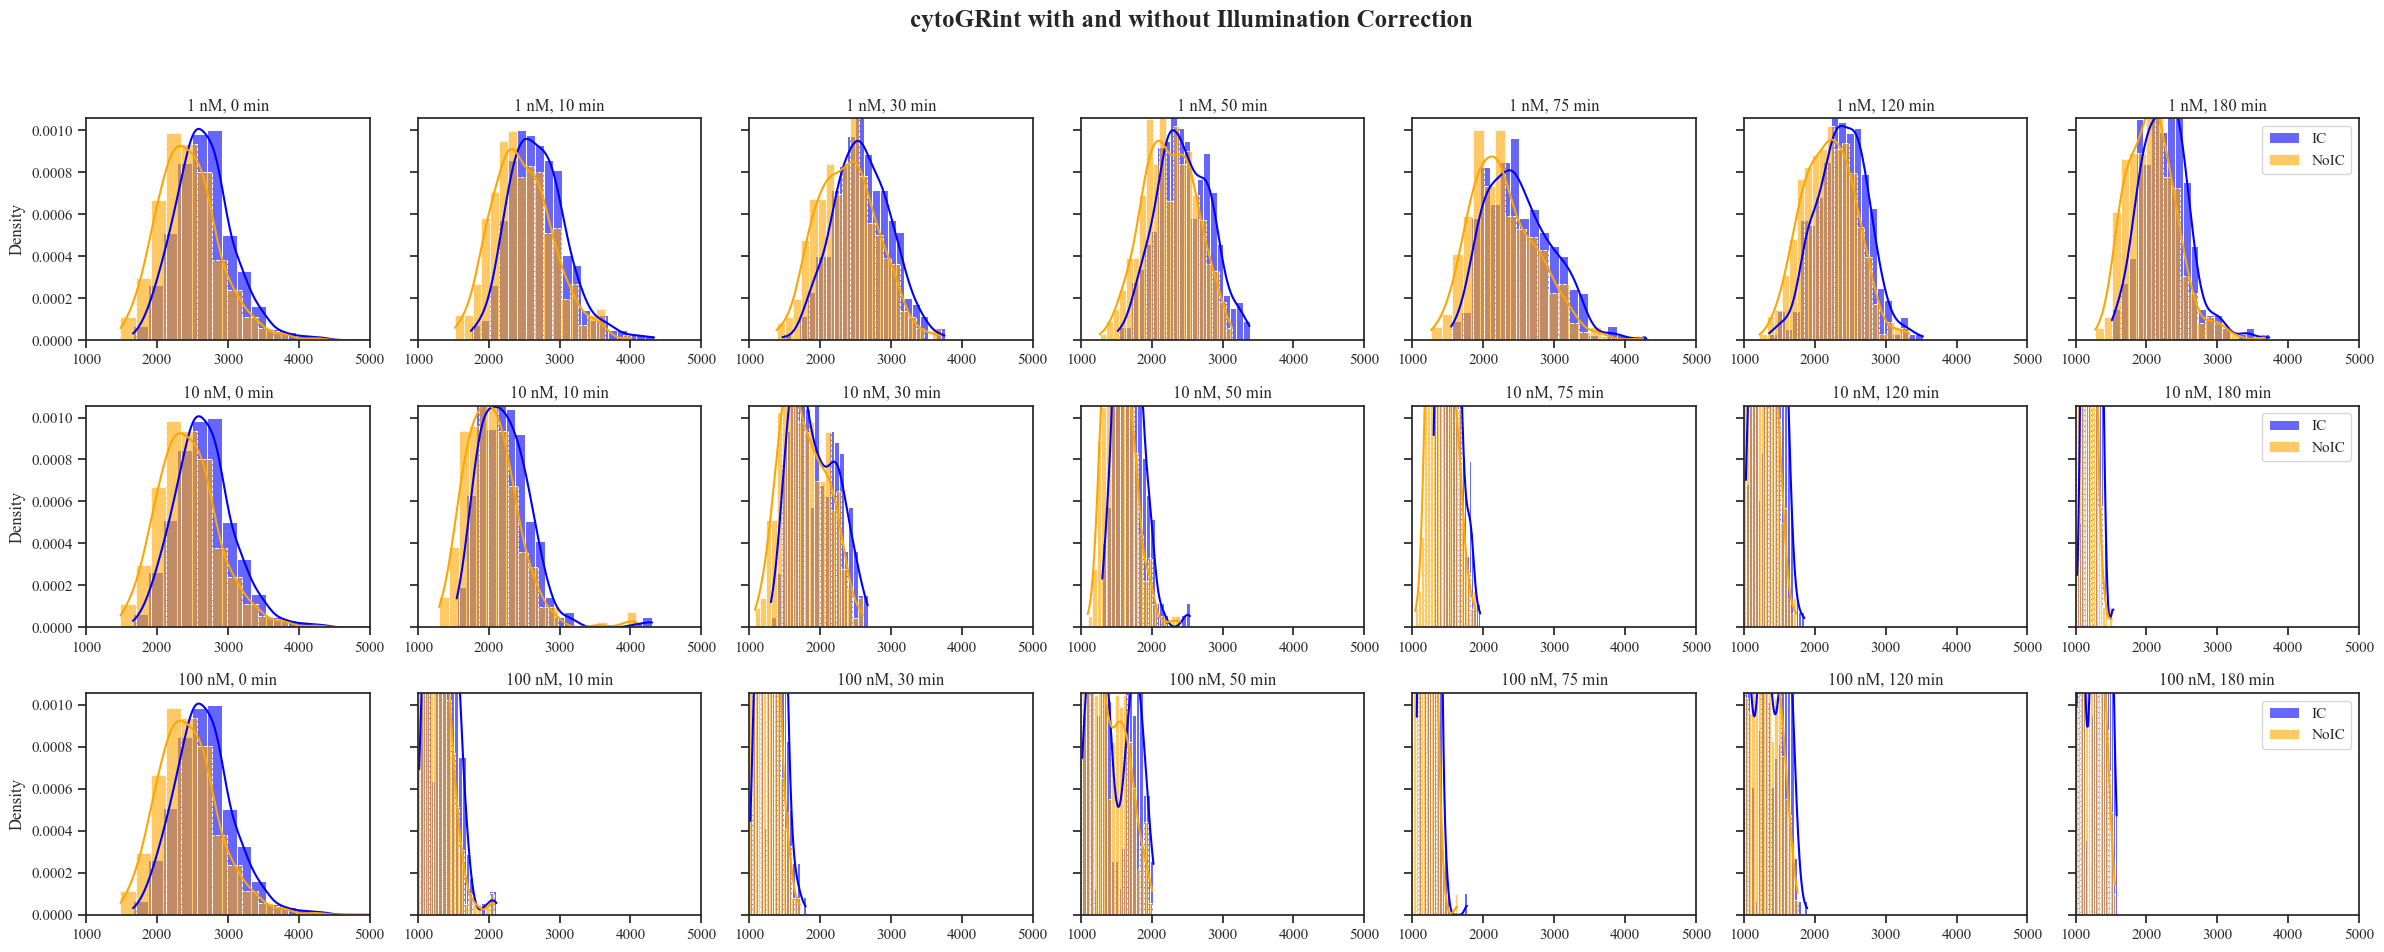

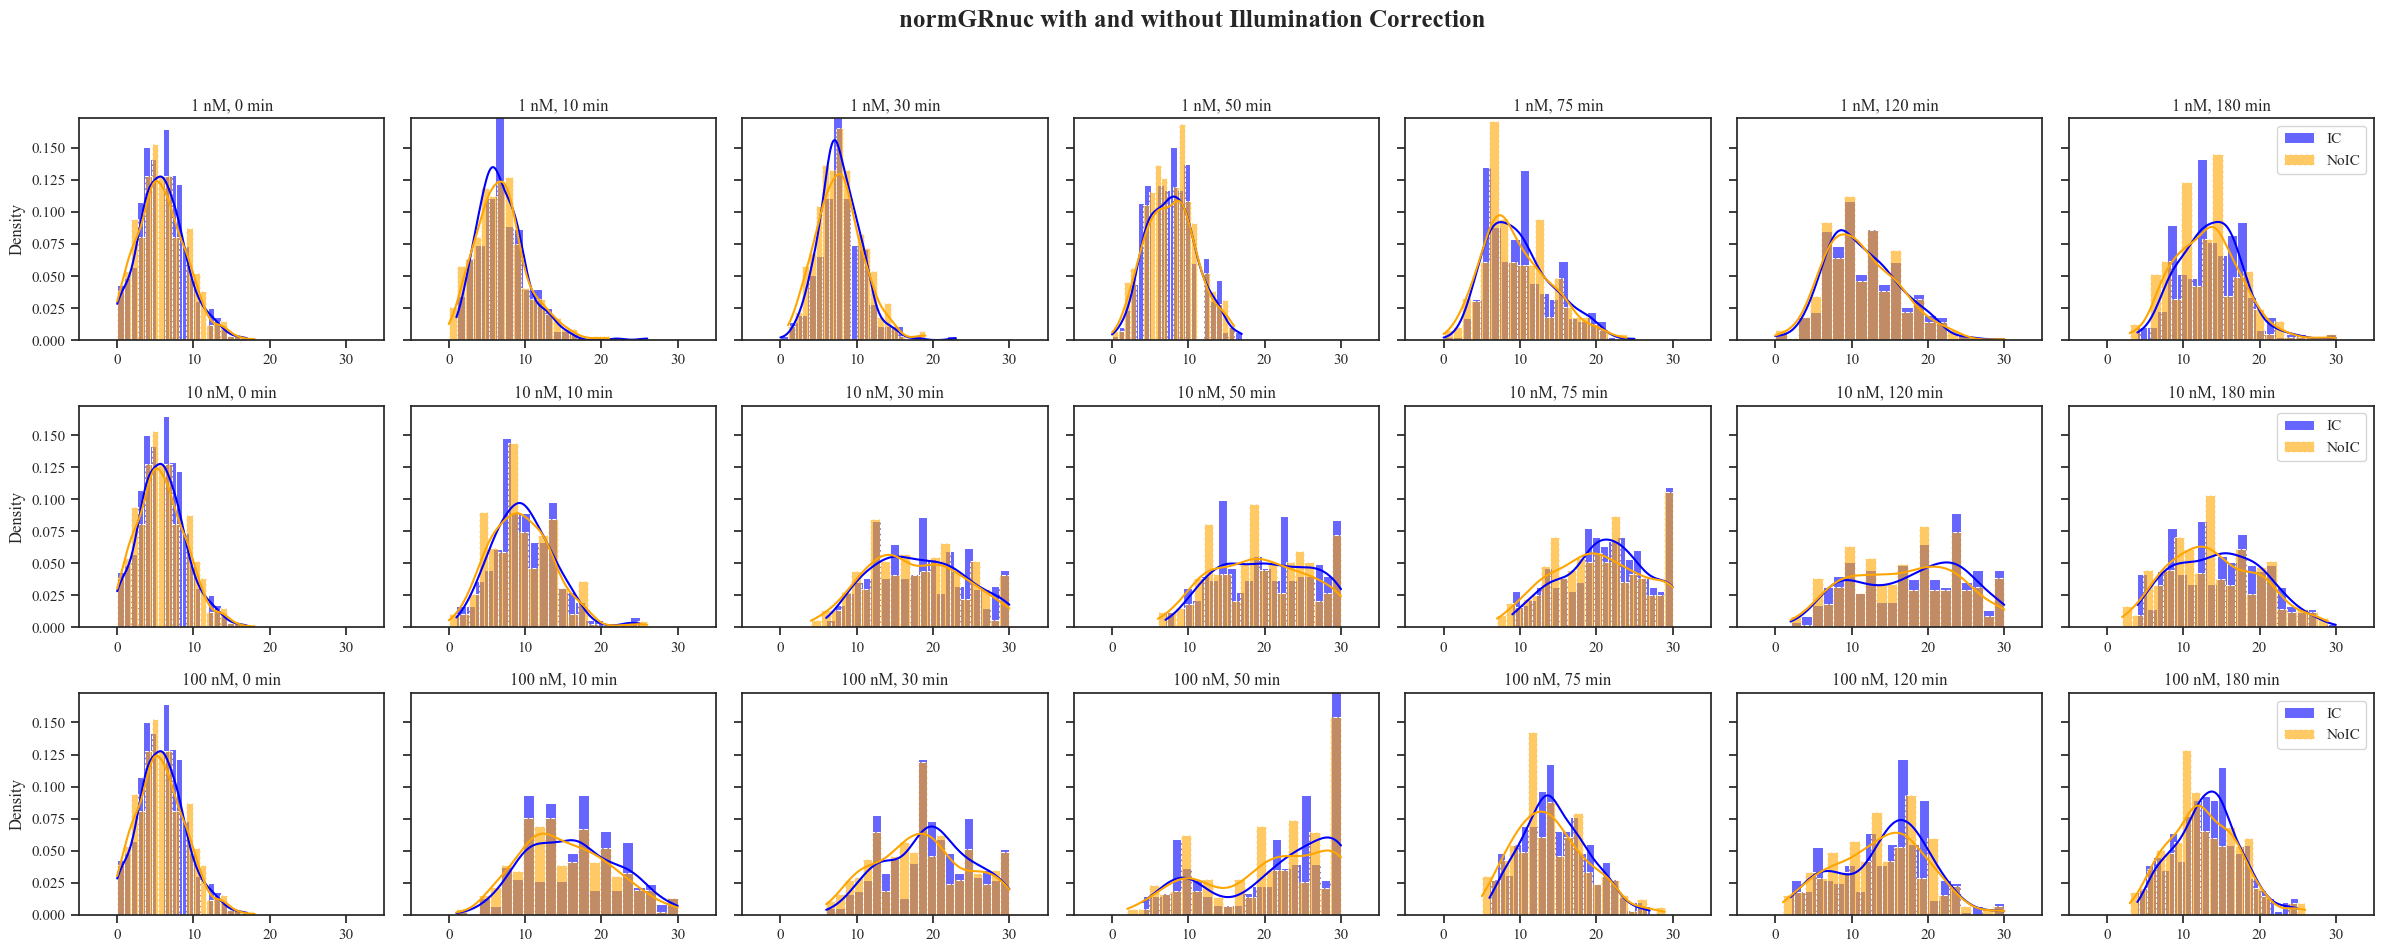

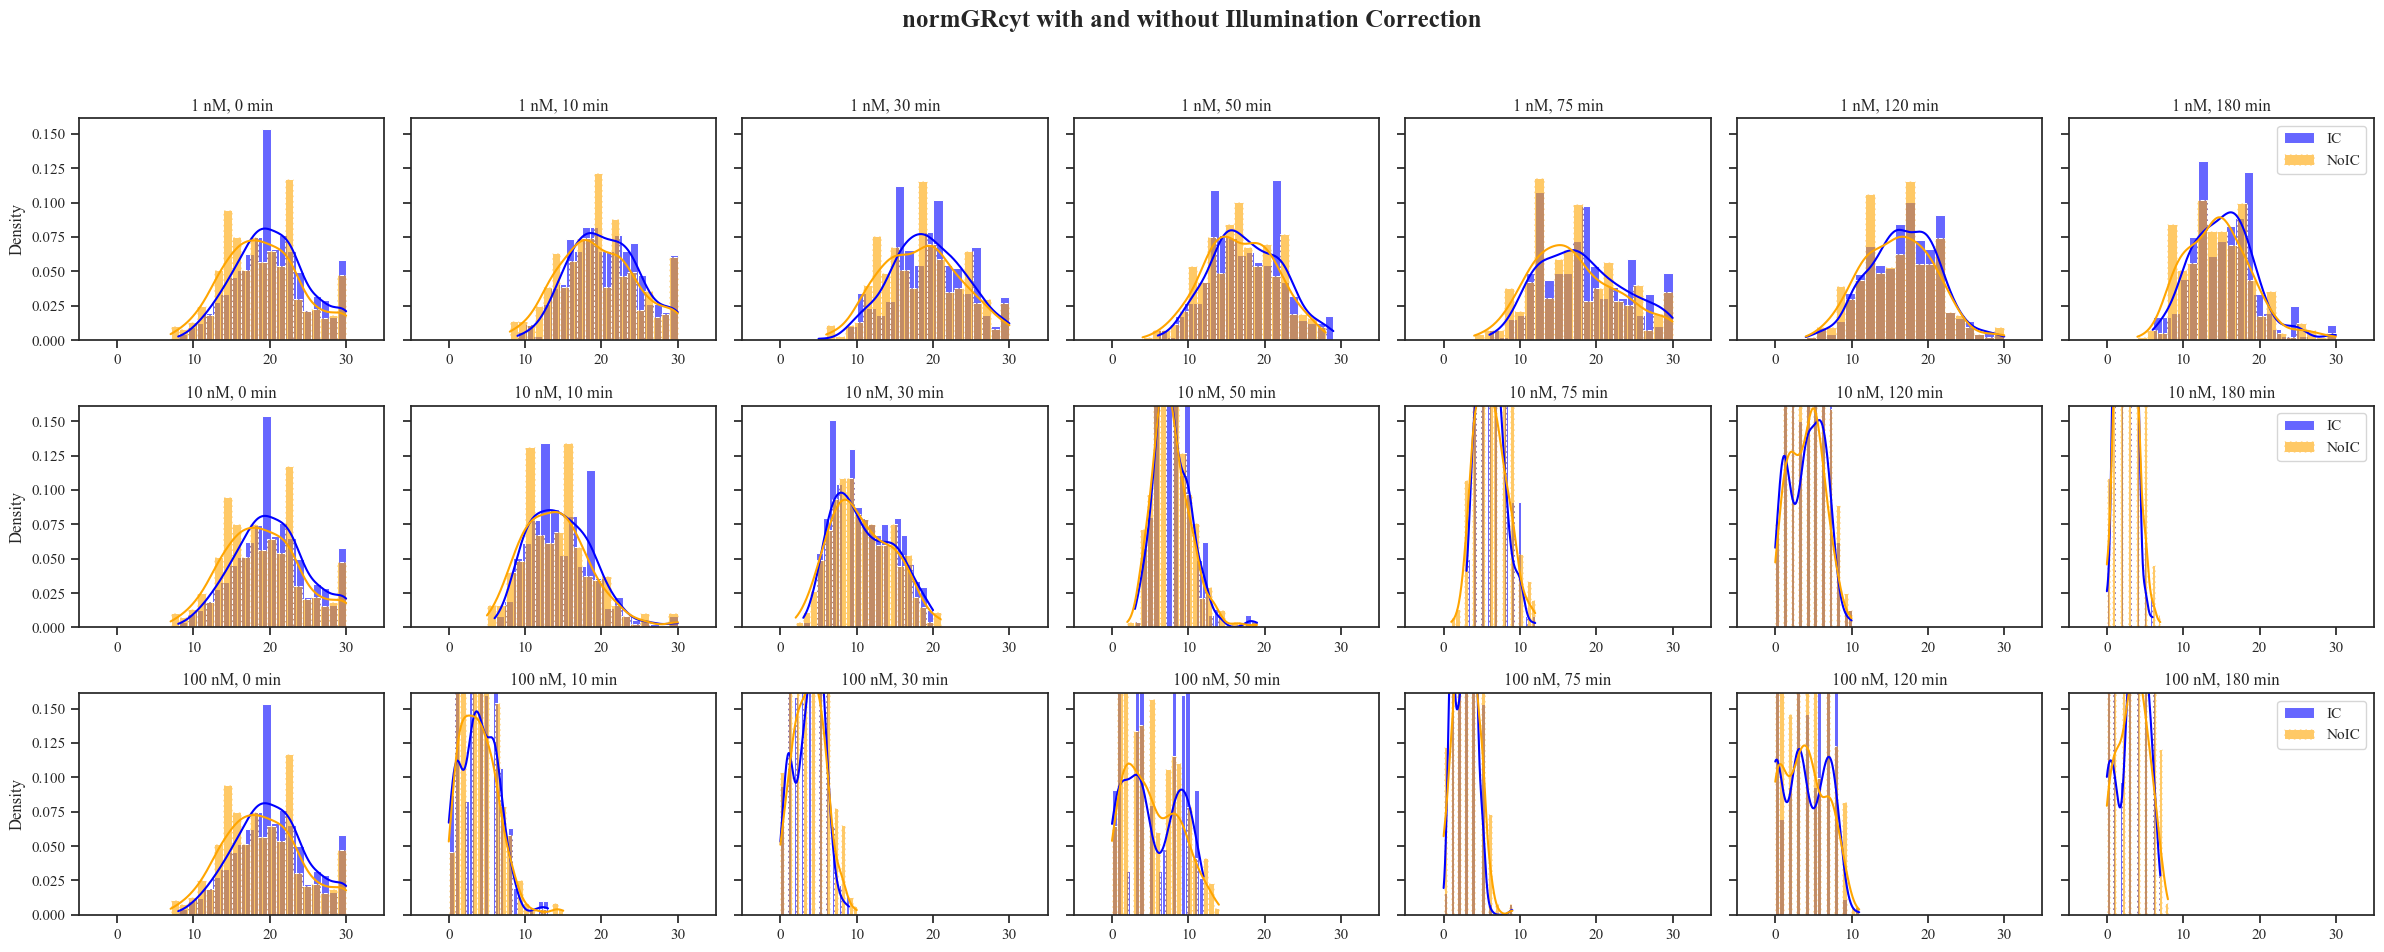

In [43]:
# Load your data
df_gr_gated = pd.read_csv('GR_ALL_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()  # IC Data
df_gr_noIC_gated = pd.read_csv('GR_ALL_noIC_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()  # NoIC Data

# Define metrics and labels
metrics = ['nucGRint', 'cytoGRint', 'normGRnuc', 'normGRcyt']
labels = {
    'nucGRint': 'Nuclear GR Intensity',
    'cytoGRint': 'Cytoplasmic GR Intensity',
    'normGRnuc': 'Normalized Nuclear GR Counts',
    'normGRcyt': 'Normalized Cytoplasmic GR Counts',
}

# Set Seaborn Theme
sns.set_theme(style="ticks", palette="colorblind", context="notebook", font='Times New Roman')

# Extract the shared 0 min data (baseline for all concentrations)
zero_min_data_ic = df_gr_gated[df_gr_gated['time'] == 0]
zero_min_data_noic = df_gr_noIC_gated[df_gr_noIC_gated['time'] == 0]

# Define desired time points including 0 min
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]
concentrations = [1, 10, 100]  # nM concentrations

# Define axis limits for each metric
axis_limits = {
    'nucGRint': (1000, 5000),
    'cytoGRint': (1000, 5000),
    'normGRnuc': (-5, 35),
    'normGRcyt': (-5, 35)
}


# Time-Dependent Histograms with 0 min included
for metric in ['nucGRint', 'cytoGRint', 'normGRnuc', 'normGRcyt']:
    fig, axes = plt.subplots(len(concentrations), len(desired_timepoints), figsize=(24, 10), sharey='row')

    for i, conc in enumerate(concentrations):
        for j, time in enumerate(desired_timepoints):
            ax = axes[i, j]

            # Use shared 0 min data when time == 0
            if time == 0:
                subset_ic = zero_min_data_ic
                subset_noic = zero_min_data_noic
            else:
                # Filter IC and NoIC data for the given concentration and time
                subset_ic = df_gr_gated[(df_gr_gated['dex_conc'] == conc) & (df_gr_gated['time'] == time)]
                subset_noic = df_gr_noIC_gated[(df_gr_noIC_gated['dex_conc'] == conc) & (df_gr_noIC_gated['time'] == time)]

            # Plot IC histogram
            sns.histplot(subset_ic, x=metric, kde=True, bins=20, color='blue', alpha=0.6, label="IC", ax=ax, stat="density")

            # Plot NoIC histogram
            sns.histplot(subset_noic, x=metric, kde=True, bins=20, color='orange', alpha=0.6, label="NoIC", ax=ax, linestyle="--", stat="density")

            # Normalize y-axis by the max density in each subplot
            ax.set_ylim(0, max(ax.get_ylim()))
            ax.set_title(f"{conc} nM, {time} min")
            ax.set_xlabel(None)
            ax.set_xlim(axis_limits[metric])
            ax.set_ylabel('Density' if j == 0 else '')
            if j == len(desired_timepoints) - 1:
                ax.legend()

    plt.suptitle(f"{metric} with and without Illumination Correction", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



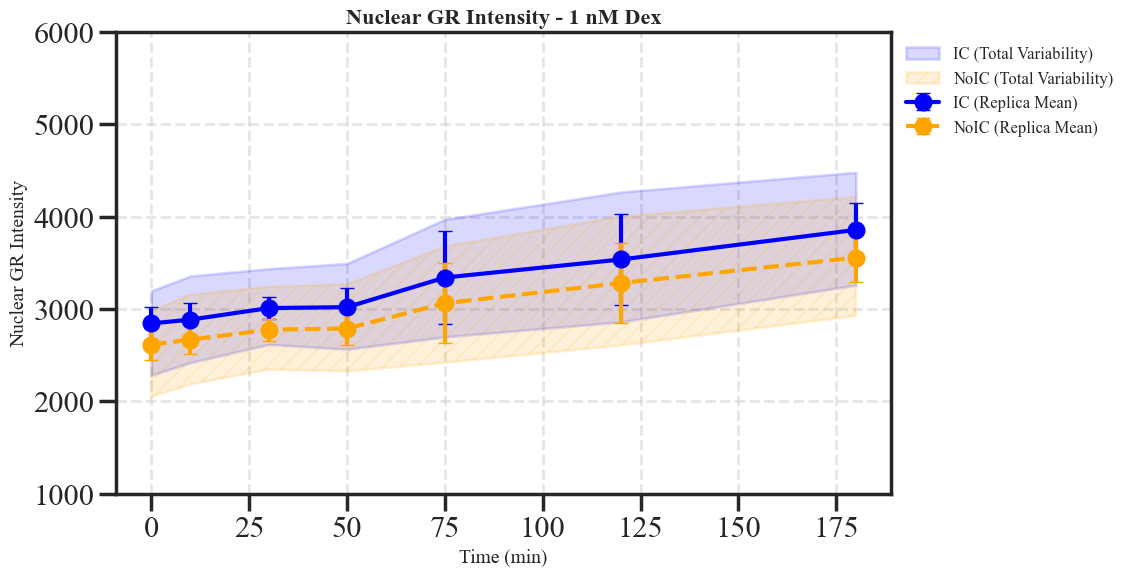

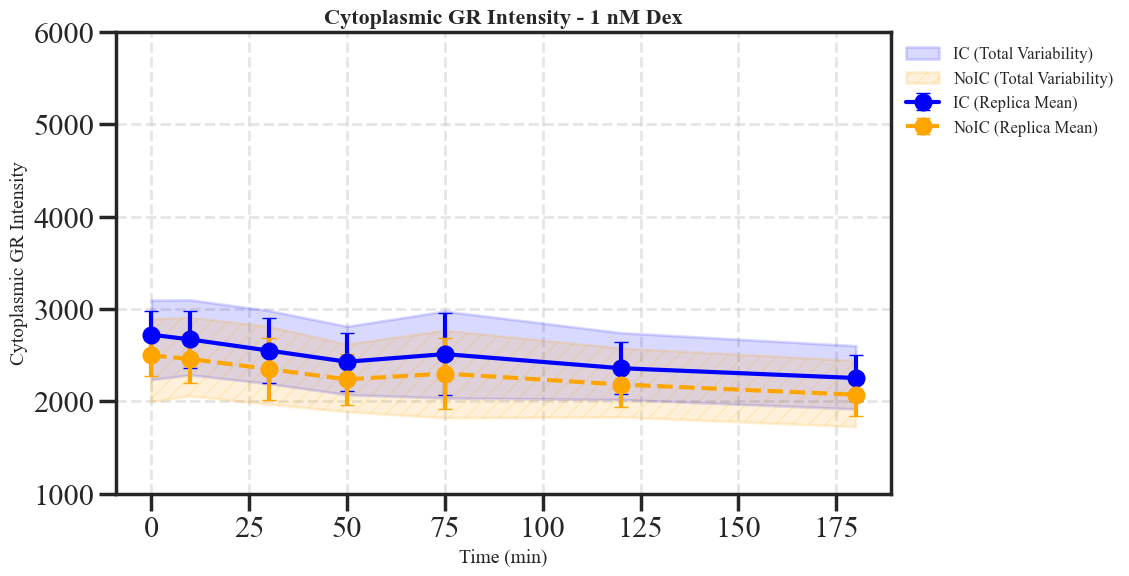

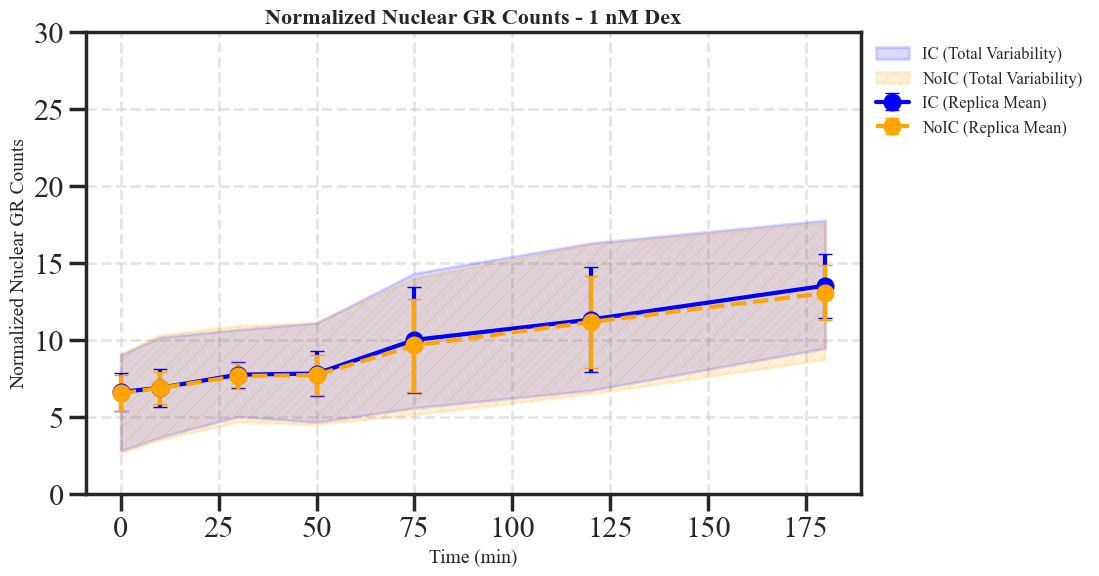

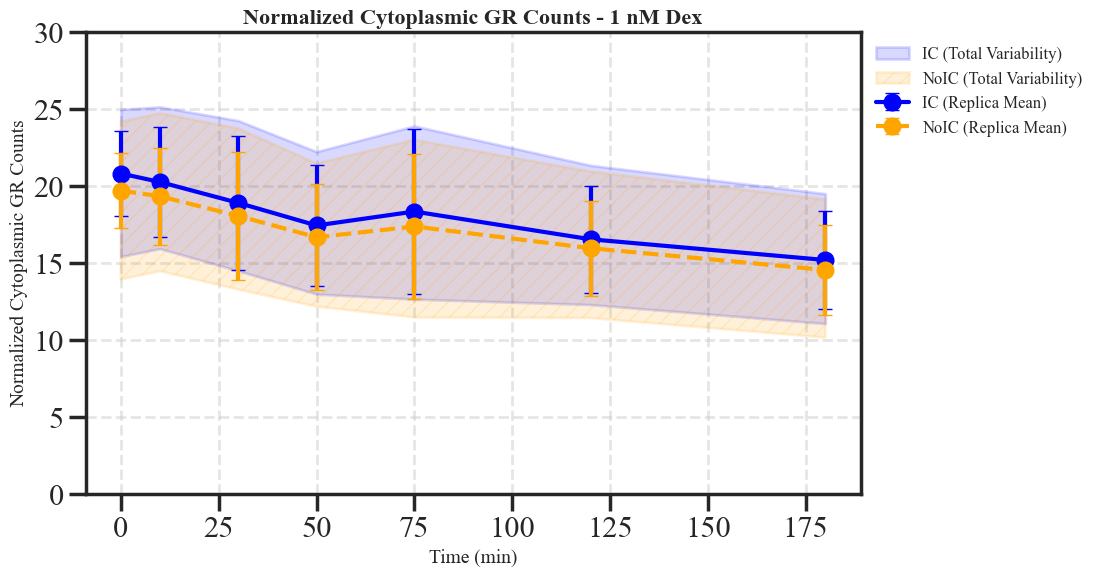

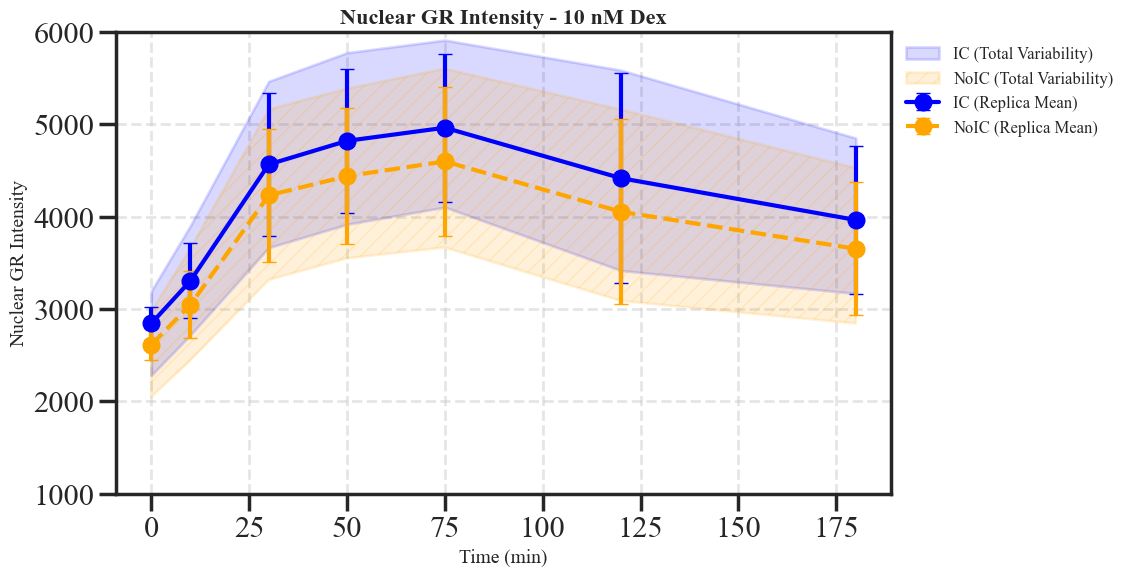

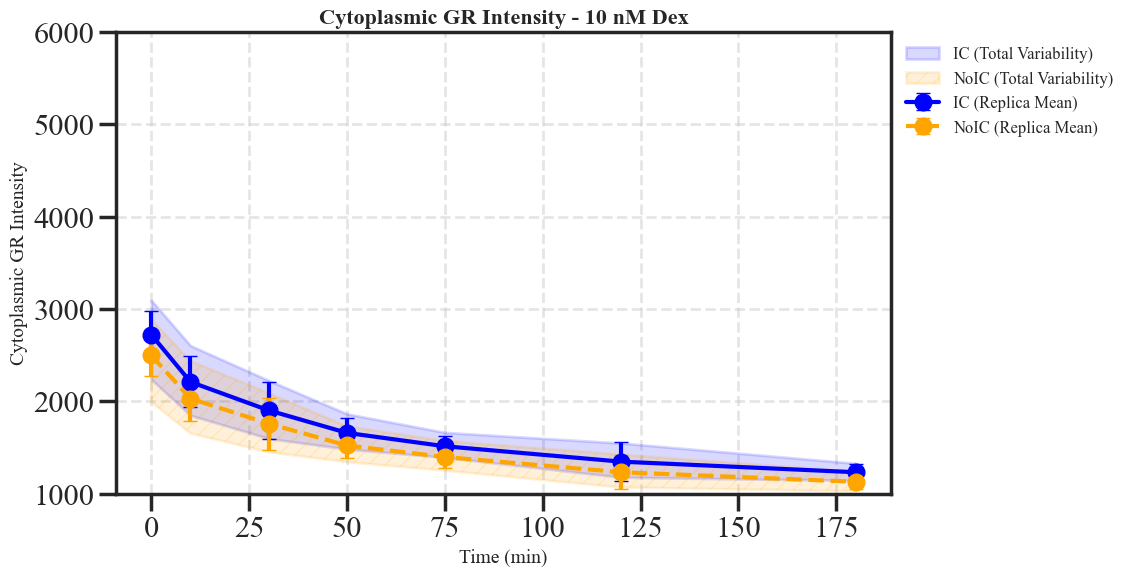

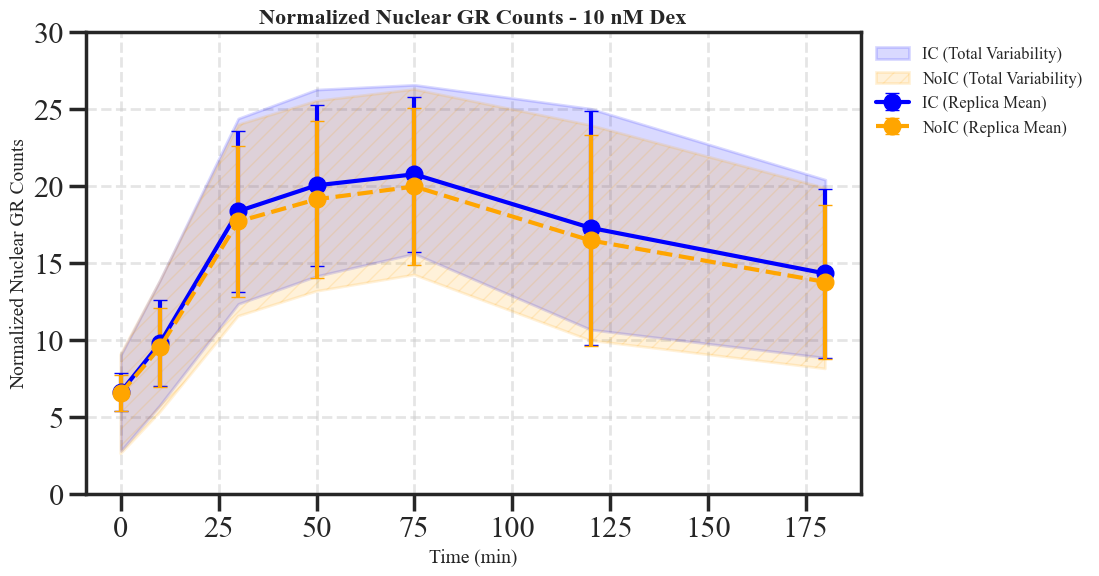

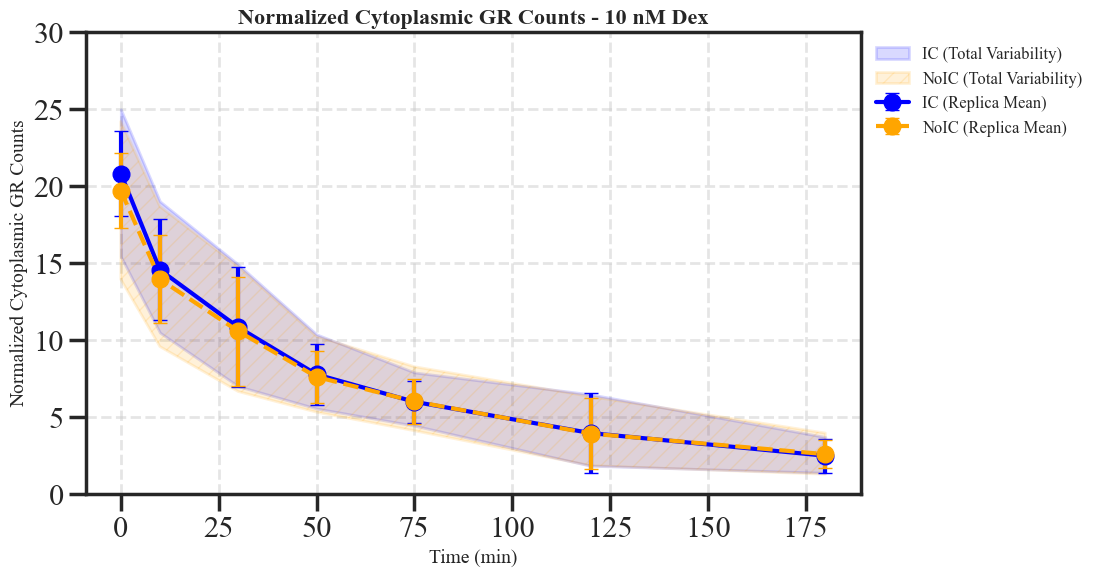

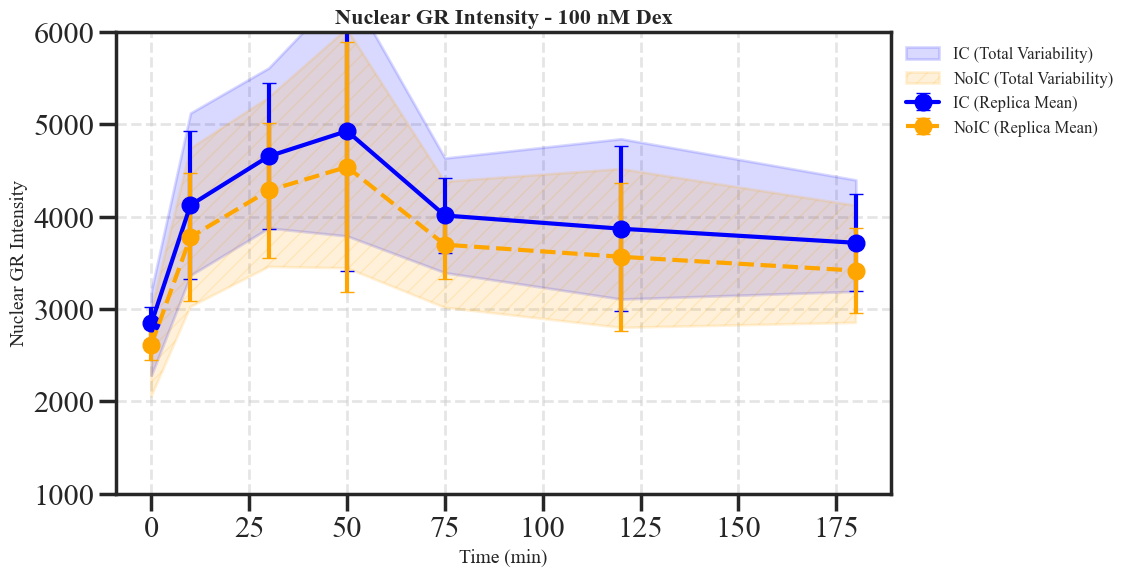

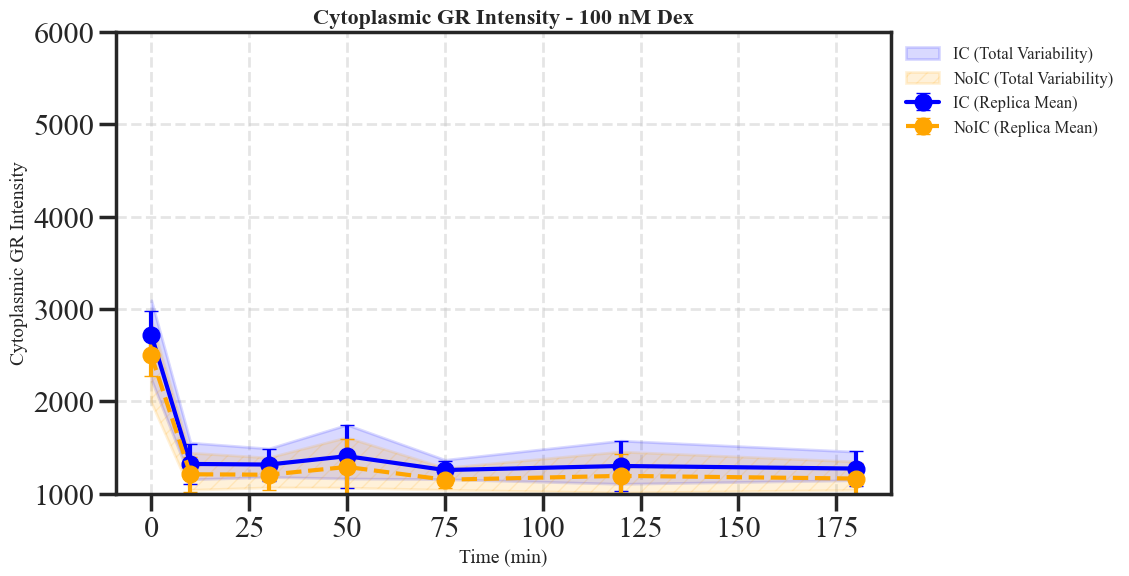

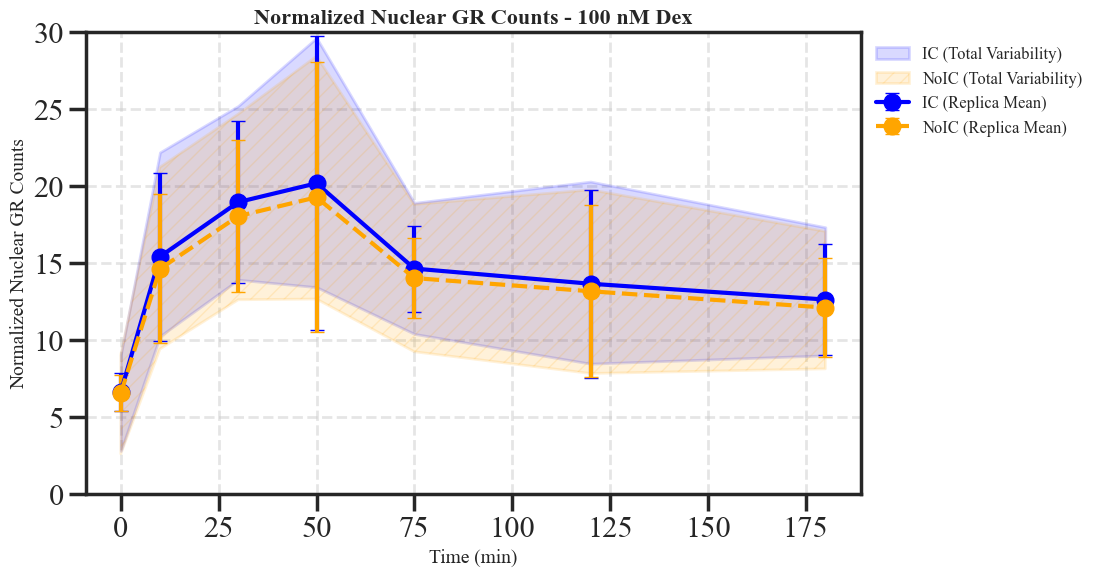

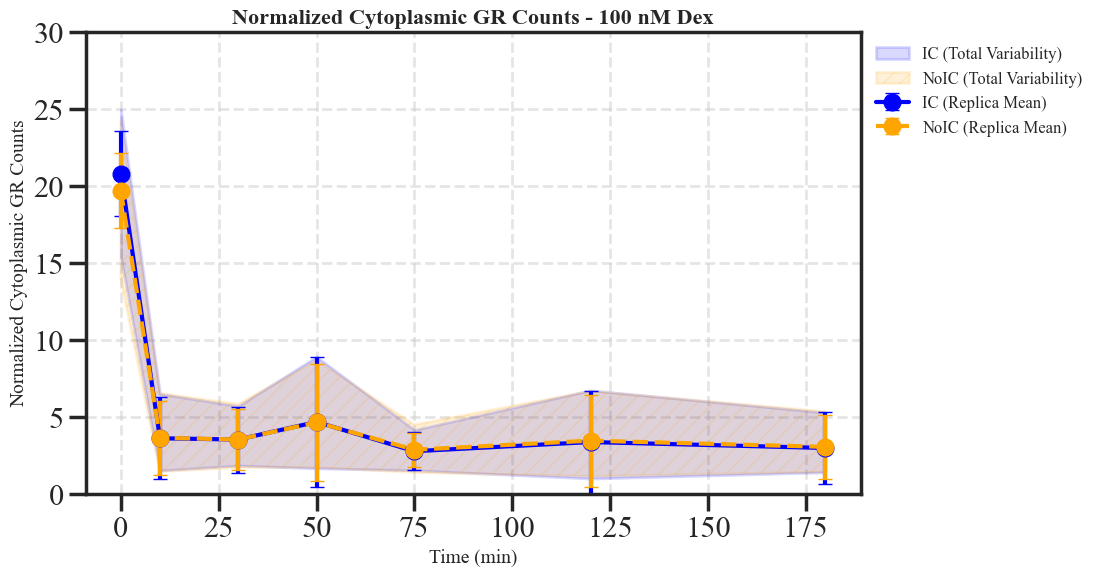

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df_ic = pd.read_csv('GR_ALL_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()  # IC Data
df_noic = pd.read_csv('GR_ALL_noIC_gated_with_CytoArea_and_normGR_Feb1925.csv').copy()  # NoIC Data

# Define metrics and labels
metrics = ['nucGRint', 'cytoGRint', 'normGRnuc', 'normGRcyt']
labels = {
    'nucGRint': 'Nuclear GR Intensity',
    'cytoGRint': 'Cytoplasmic GR Intensity',
    'normGRnuc': 'Normalized Nuclear GR Counts',
    'normGRcyt': 'Normalized Cytoplasmic GR Counts',
}

# Define time points and concentrations
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]
concentrations = [1, 10, 100]  # nM concentrations

# Define axis limits
axis_limits = {
    'nucGRint': (1000, 6000),
    'cytoGRint': (1000, 6000),
    'normGRnuc': (0, 30),
    'normGRcyt': (0, 30)
}

# Set Seaborn theme
sns.set_theme(style="ticks", palette="colorblind", context="poster", font="Times New Roman")

# Process IC and NoIC data to compute means and standard deviations
def compute_summary(df):
    """
    Computes mean and standard deviation of replica means and overall data spread.
    """
    # Compute replica means
    replica_means = df.groupby(['dex_conc', 'time', 'replica']).agg({m: 'mean' for m in metrics}).reset_index()
    
    # Compute summary statistics for replica means
    summary_stats = replica_means.groupby(['dex_conc', 'time']).agg({m: ['mean', 'std'] for m in metrics}).reset_index()
    
    # Rename columns
    summary_stats.columns = ['dex_conc', 'time'] + [f"{m}_{stat}" for m in metrics for stat in ['mean', 'std']]
    
    # Compute overall mean and standard deviation across all individual values
    overall_stats = df.groupby(['dex_conc', 'time']).agg({m: ['mean', 'std'] for m in metrics}).reset_index()
    
    # Rename columns
    overall_stats.columns = ['dex_conc', 'time'] + [f"{m}_overall_{stat}" for m in metrics for stat in ['mean', 'std']]
    
    return summary_stats, overall_stats

# Compute summary statistics for both datasets
summary_ic, overall_ic = compute_summary(df_ic)
summary_noic, overall_noic = compute_summary(df_noic)

# Extract 0 min baseline data
baseline_ic = summary_ic[summary_ic['time'] == 0]
baseline_noic = summary_noic[summary_noic['time'] == 0]

baseline_overall_ic = overall_ic[overall_ic['time'] == 0]
baseline_overall_noic = overall_noic[overall_noic['time'] == 0]

# Loop through concentrations and metrics to create line plots
for conc in concentrations:
    for metric in metrics:
        plt.figure(figsize=(10, 6))

        # Extract subsets for the current concentration
        subset_ic = summary_ic[(summary_ic['dex_conc'] == conc) & (summary_ic['time'].isin(desired_timepoints))]
        subset_noic = summary_noic[(summary_noic['dex_conc'] == conc) & (summary_noic['time'].isin(desired_timepoints))]

        subset_overall_ic = overall_ic[(overall_ic['dex_conc'] == conc) & (overall_ic['time'].isin(desired_timepoints))]
        subset_overall_noic = overall_noic[(overall_noic['dex_conc'] == conc) & (overall_noic['time'].isin(desired_timepoints))]

        # Add 0 min time point if missing
        if 0 not in subset_ic['time'].values:
            subset_ic = pd.concat([baseline_ic, subset_ic], ignore_index=True)
        if 0 not in subset_noic['time'].values:
            subset_noic = pd.concat([baseline_noic, subset_noic], ignore_index=True)
        if 0 not in subset_overall_ic['time'].values:
            subset_overall_ic = pd.concat([baseline_overall_ic, subset_overall_ic], ignore_index=True)
        if 0 not in subset_overall_noic['time'].values:
            subset_overall_noic = pd.concat([baseline_overall_noic, subset_overall_noic], ignore_index=True)

        # Plot IC data (solid line)
        plt.errorbar(subset_ic['time'], subset_ic[f"{metric}_mean"], 
                     yerr=subset_ic[f"{metric}_std"], fmt='-o', color='blue', capsize=5, label="IC (Replica Mean)")

        # Shading for IC total variability
        plt.fill_between(subset_overall_ic['time'],
                         subset_overall_ic[f"{metric}_overall_mean"] - subset_overall_ic[f"{metric}_overall_std"],
                         subset_overall_ic[f"{metric}_overall_mean"] + subset_overall_ic[f"{metric}_overall_std"],
                         color='blue', alpha=0.15, label="IC (Total Variability)")

        # Plot NoIC data (dashed line)
        plt.errorbar(subset_noic['time'], subset_noic[f"{metric}_mean"], 
                     yerr=subset_noic[f"{metric}_std"], fmt='--o', color='orange', capsize=5, label="NoIC (Replica Mean)")

        # Shading for NoIC total variability (patterned or different alpha)
        plt.fill_between(subset_overall_noic['time'],
                         subset_overall_noic[f"{metric}_overall_mean"] - subset_overall_noic[f"{metric}_overall_std"],
                         subset_overall_noic[f"{metric}_overall_mean"] + subset_overall_noic[f"{metric}_overall_std"],
                         color='orange', alpha=0.15, label="NoIC (Total Variability)", hatch='//')

        # Customize plot
        plt.title(f"{labels[metric]} - {conc} nM Dex", fontsize=16, fontweight='bold')
        plt.xlabel("Time (min)", fontsize=14)
        plt.ylabel(labels[metric], fontsize=14)
        plt.ylim(axis_limits[metric])
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))

        # Show the plot
        plt.show()

In [ ]:
df_dusp_gated.keys()

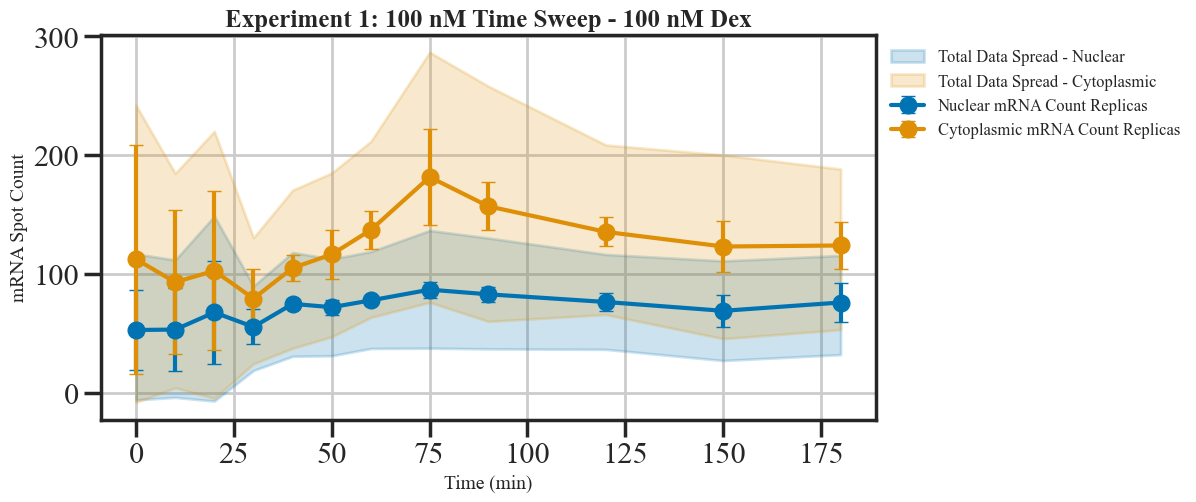

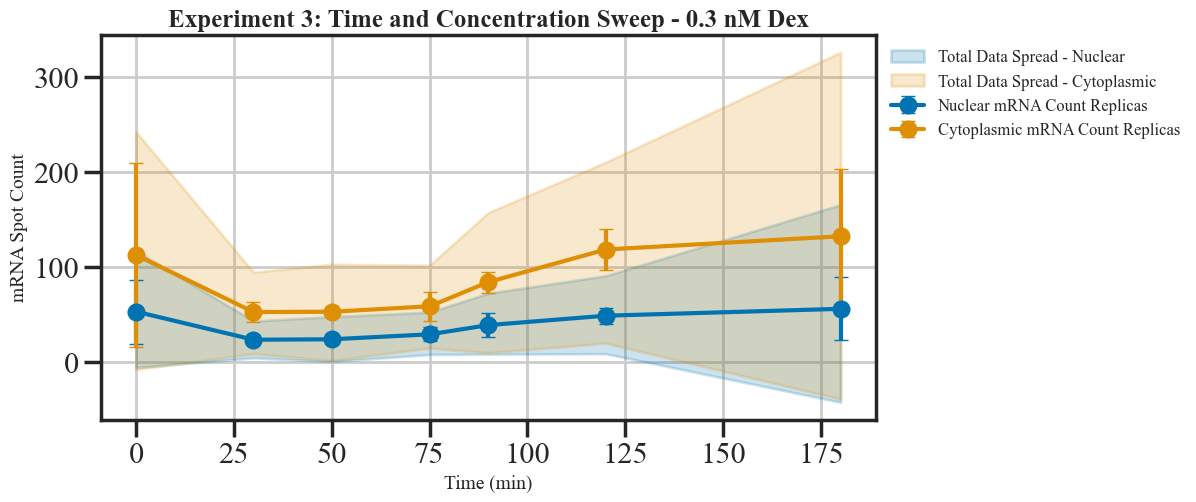

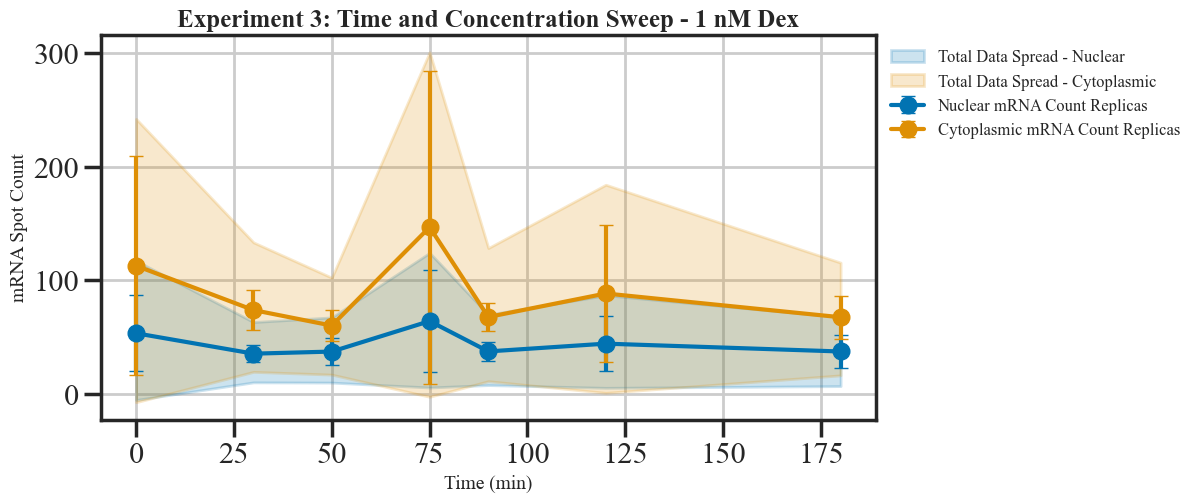

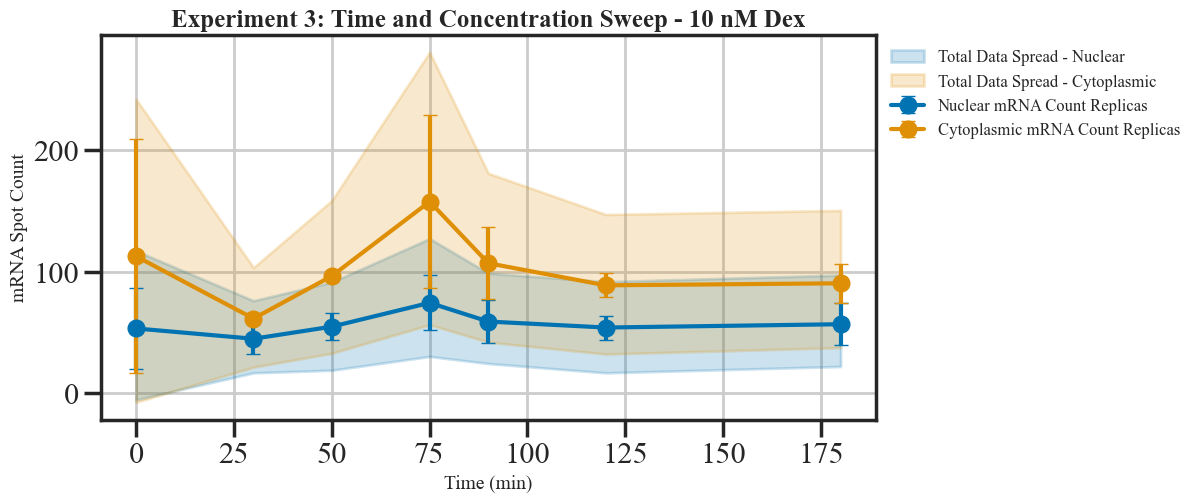

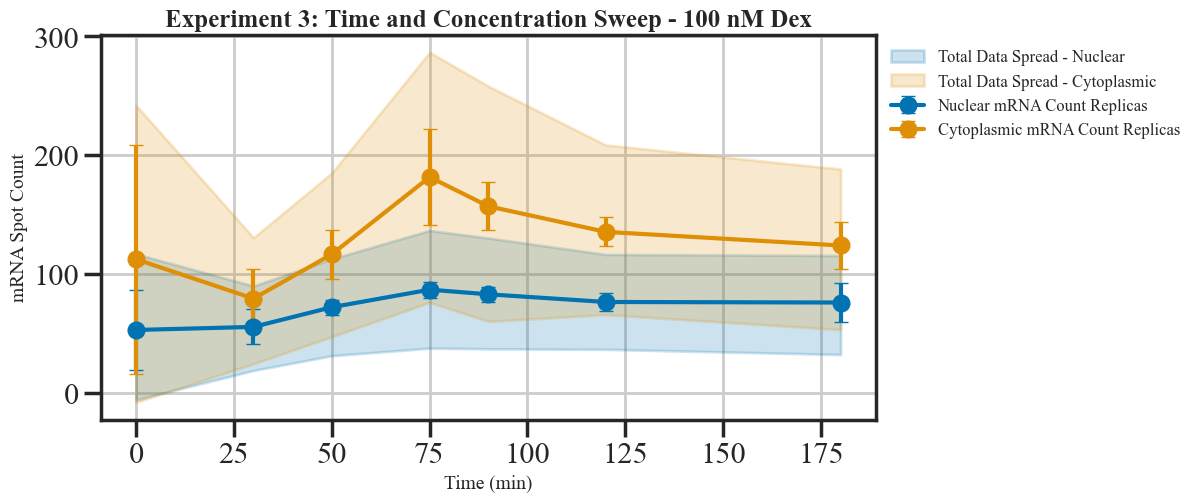

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make a copy of the DUSP1 data
DUSP1_data = df_dusp_gated.copy()

# Experiment 1: 100 nM Dex time sweep with 12 timepoints
df_expt1 = DUSP1_data[DUSP1_data['replica'].isin(['D', 'E', 'F', 'M', 'N'])]
expt1_timepoints = [10, 20, 30, 40, 50, 60, 75, 90, 120, 150, 180]
expt1_concs = [100]

# Experiment 3: Time and concentration sweep
df_expt3 = DUSP1_data[DUSP1_data['replica'].isin(['J', 'K', 'L'])]
expt3_concs = [0.3, 1, 10, 100]
expt3_timepoints = [30, 50, 75, 90, 120, 180]

# Calculate means for each replica
replica_means = DUSP1_data.groupby(['dex_conc', 'time', 'replica']).agg({
    'num_nuc_spots': 'mean',
    'num_cyto_spots': 'mean'
}).reset_index()

# Calculate the mean and standard deviation of the replica means
summary_stats = replica_means.groupby(['dex_conc', 'time']).agg({
    'num_nuc_spots': ['mean', 'std'],
    'num_cyto_spots': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
summary_stats.columns = ['dex_conc', 'time', 'mean_nuc_count', 'std_nuc_count', 'mean_cyto_count', 'std_cyto_count']

# Calculate overall mean and standard deviation for each concentration and time point
overall_stats = DUSP1_data.groupby(['dex_conc', 'time']).agg({
    'num_nuc_spots': ['mean', 'std'],
    'num_cyto_spots': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
overall_stats.columns = ['dex_conc', 'time', 'overall_mean_nuc', 'overall_std_nuc', 'overall_mean_cyto', 'overall_std_cyto']

# Extract 0 min data (shared baseline from dex_conc == 0)
zero_min_summary = summary_stats[summary_stats['time'] == 0]
zero_min_overall = overall_stats[overall_stats['time'] == 0]

# Set Style
sns.set_theme(style="ticks", palette="colorblind", context="poster", font='times new roman')

# Define the color palette for Nuclear and Cytoplasmic intensities
colors_nuc_cyto = sns.color_palette("colorblind", 2)  # Two colors: one for Nuclear, one for Cytoplasmic

# Loop through the three experiments
experiments = {
    "Experiment 1: 100 nM Time Sweep": (expt1_concs, expt1_timepoints),
    # "Experiment 2: 75 min Concentration Sweep": (expt2_concs, expt2_timepoints),
    "Experiment 3: Time and Concentration Sweep": (expt3_concs, expt3_timepoints),
}

for expt_name, (concs, timepoints) in experiments.items():
    for conc in concs:
        # Filter data for plotting
        subset_summary = summary_stats[(summary_stats['dex_conc'] == conc) & (summary_stats['time'].isin(timepoints))]
        subset_overall = overall_stats[(overall_stats['dex_conc'] == conc) & (overall_stats['time'].isin(timepoints))]

        # Add 0 min time point to all subsets if not already present
        if 0 not in subset_summary['time'].values:
            subset_summary = pd.concat([zero_min_summary, subset_summary], ignore_index=True)
        if 0 not in subset_overall['time'].values:
            subset_overall = pd.concat([zero_min_overall, subset_overall], ignore_index=True)

        plt.figure(figsize=(10, 5))

        # Plot Nuclear mRNA Count Mean with Error Bars
        plt.errorbar(subset_summary['time'], subset_summary['mean_nuc_count'],
                     yerr=subset_summary['std_nuc_count'], fmt='-o', color=colors_nuc_cyto[0], capsize=5,
                     label='Nuclear mRNA Count Replicas')

        # Filling between std deviations for overall data - Nuclear
        plt.fill_between(subset_overall['time'],
                         subset_overall['overall_mean_nuc'] - subset_overall['overall_std_nuc'],
                         subset_overall['overall_mean_nuc'] + subset_overall['overall_std_nuc'],
                         color=colors_nuc_cyto[0], alpha=0.2, label='Total Data Spread - Nuclear')

        # Plot Cytoplasmic mRNA Count Mean with Error Bars
        plt.errorbar(subset_summary['time'], subset_summary['mean_cyto_count'],
                     yerr=subset_summary['std_cyto_count'], fmt='-o', color=colors_nuc_cyto[1], capsize=5,
                     label='Cytoplasmic mRNA Count Replicas')

        # Filling between std deviations for overall data - Cytoplasmic
        plt.fill_between(subset_overall['time'],
                         subset_overall['overall_mean_cyto'] - subset_overall['overall_std_cyto'],
                         subset_overall['overall_mean_cyto'] + subset_overall['overall_std_cyto'],
                         color=colors_nuc_cyto[1], alpha=0.2, label='Total Data Spread - Cytoplasmic')

        # Customize the plot
        plt.title(f"{expt_name} - {conc} nM Dex", fontsize=18, fontweight='bold')
        plt.xlabel('Time (min)', fontsize=14)
        plt.ylabel('mRNA Spot Count', fontsize=14)
        plt.grid(True)
        plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))


        # Show the plot
        plt.show()


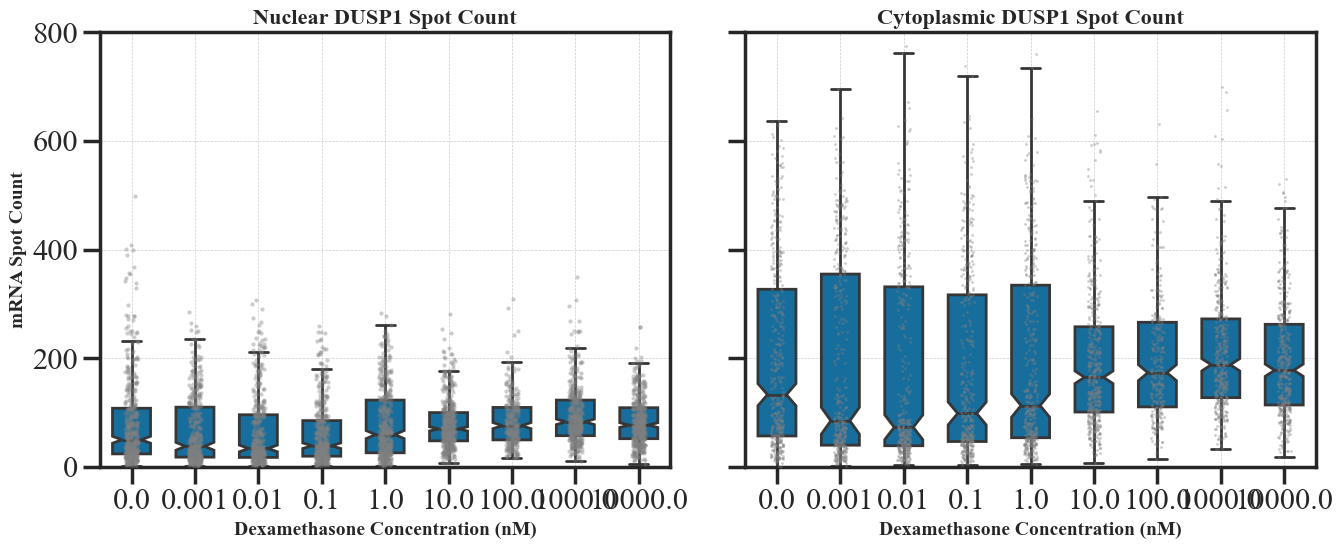

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy of the DUSP1 data
DUSP1_data = df_dusp_gated.copy()

# Experiment 2: 75 min concentration sweep (Replicas G, H, I)
df_expt2 = DUSP1_data[DUSP1_data['replica'].isin(['G', 'H', 'I'])].copy()

# Set Seaborn style
sns.set_theme(style="ticks", palette="colorblind", context="poster", font='times new roman')

# Melt DataFrame for Seaborn Box Plot
melted_expt2_data = df_expt2.melt(id_vars=['dex_conc'], value_vars=['num_nuc_spots', 'num_cyto_spots'],
                                  var_name='Spot_Type', value_name='Spot_Count')

# Update labels for readability
melted_expt2_data['Spot_Type'] = melted_expt2_data['Spot_Type'].replace({
    'num_nuc_spots': 'Nuclear Spots',
    'num_cyto_spots': 'Cytoplasmic Spots'
})

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Nuclear Spots Plot
ax1 = axes[0]
nuc_data = melted_expt2_data[melted_expt2_data['Spot_Type'] == 'Nuclear Spots']
sns.boxplot(x='dex_conc', y='Spot_Count', data=nuc_data, linewidth=2, width=0.6, showfliers=False, notch=True, ax=ax1)
sns.stripplot(x='dex_conc', y='Spot_Count', data=nuc_data, dodge=True, jitter=True, size=3, alpha=0.4, ax=ax1, marker='o', edgecolor='black', color='gray')

ax1.set_xlabel("Dexamethasone Concentration (nM)", fontsize=14, fontweight='bold')
ax1.set_ylabel("mRNA Spot Count", fontsize=14, fontweight='bold')
ax1.set_title("Nuclear DUSP1 Spot Count", fontsize=16, fontweight='bold')
ax1.grid(True, linestyle="--", linewidth=0.5)

# Cytoplasmic Spots Plot
ax2 = axes[1]
cyto_data = melted_expt2_data[melted_expt2_data['Spot_Type'] == 'Cytoplasmic Spots']
sns.boxplot(x='dex_conc', y='Spot_Count', data=cyto_data, linewidth=2, width=0.6, showfliers=False, notch=True, ax=ax2)
sns.stripplot(x='dex_conc', y='Spot_Count', data=cyto_data, dodge=True, jitter=True, size=2, alpha=0.4, ax=ax2, marker='o', edgecolor='black', color='gray')

ax2.set_xlabel("Dexamethasone Concentration (nM)", fontsize=14, fontweight='bold')
ax2.set_ylabel("")  # Remove redundant label
ax2.set_title("Cytoplasmic DUSP1 Spot Count", fontsize=16, fontweight='bold')
ax2.grid(True, linestyle="--", linewidth=0.5)

# Set Y-limits 
ax1.set_ylim(0, 300)
ax2.set_ylim(0, 800)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
